# Домашнее задание №1

В данной работе вы будете изучать, как различные факторы влияют на вероятность того, что индивид оформит подписку на онлайн кинотеатр. Для этого используйте данные “homework.rds”. Чтобы считать соответствующие данные в R необходимо воспользоваться функцией “readRDS”.
Данные содержат информацию о следующих индивидуальных характеристиках:
* income — доход
* age — возраст
* internet — доля свободного времени, проводимого в интернете
* series — количество просмотренных за год сериалов
* health — субъективная оценка здоровья
* male — половая принадлежность
* marriage — состоит в официальном браке
* residence — место проживания
* cat — факт наличия кота
* news — субъективная оценка степени, в которой индивид интересуется новостями
* sub — факт наличия подписки на онлайн кинотеатр (зависимая переменная)
* TV — индивид смотрит телевизор не реже раза в неделю

In [1]:
# pip install rpy2

In [2]:
import pandas as pd
import numpy as np
import scipy
from tqdm.auto import tqdm
import pyreadr

import statsmodels.api as sm
from statsmodels.api import OLS, Probit, Logit
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 8

%load_ext rpy2.ipython

In [3]:
%%R

#install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
library("GJRM")                             
library("pbivnorm")  
library("pROC")
library("DescTools")
library("glmx") 
library("numDeriv")
library("margins")

R[write to console]: Загрузка требуемого пакета: mgcv

R[write to console]: Загрузка требуемого пакета: nlme

R[write to console]: This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

R[write to console]: 
This is GJRM 0.2-6.
For overview type 'help("GJRM-package")'.


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Присоединяю пакет: ‘pROC’


R[write to console]: Следующие объекты скрыты от ‘package:stats’:

    cov, smooth, var




In [4]:
result = pyreadr.read_r('homework.Rds') 
df = result[None]  

In [5]:
df.head()

,income,age,internet,series,health,male,marriage,residence,cat,news,sub,TV
0,6000.0,75.0,0.61,9.0,medium,0,1,City,0,-3.0,0.0,1.0
1,7000.0,33.0,0.05,5.0,medium,0,1,Capital,0,-5.0,0.0,0.0
2,37000.0,30.0,0.15,9.0,good,1,0,City,0,2.0,1.0,1.0
3,18000.0,50.0,0.37,1.0,bad,0,0,Village,1,4.0,0.0,0.0
4,7000.0,24.0,0.24,7.0,bad,0,0,City,0,-3.0,0.0,0.0


In [6]:
df.shape

(5000, 12)

## Часть 1. Теория и гипотезы

$\bf{1.1.}$ Выберите независимые переменные. Кратко теоретически обоснуйте выбор каждой из них: не обязательно со ссылками на литературу, достаточно здравого смысла. Укажите и кратко обоснуйте предполагаемые направления эффектов. При этом вам понадобится как минимум одна непрерывная переменная (например, возраст или доход) и одна дамми переменная (например, половая принадлежность или брак). Не рекомендуется брать больше трех различных независимых переменных, не считая их нелинейных преобразований: квадрат, логарифм, перемножение с целью получения переменной взаимодействия и т.д.

$\bf{\text{Мое решение:}}$ 

В качестве независимых переменных возьмем возраст (непрерывная), пол (бинарная) и кол-во просмотренных за год сериалов (будем считать ее по аналогии с возрастом непрерывной). 

Возраст будет входить в мою модель нелинейно: с квадратом, так как вполне возможно, что очень молодые индивиды не будут иметь подписку (не знаю, что это такое; не интересен контент в подписке), с увеличением возраста (подростки, люди 20-40 лет) люди хотят быть на волне, смотреть актуальные сериалы/фильмы, поэтому захотят иметь подписку на сервис. Однако, более старые люди реже пользуются онлайн-сервисами: они либо не знают, что это, либо онлайн-просмотр фильмов им неинтересен. Таким образом, предполагаю, что коэффициент при квадрате возраста будет отрицательным, а пик вероятности иметь подписку будет достигаться где-то при 25 годах (при прочих равных факторах)

Мне кажется, что представители женского пола чаще смотрят фильмы/сериалы (возможно, потому что у них на это больше свободного времени), поэтому коэффициент при поле, по моим предположениям, должен быть отрицательным (1 $-$ мужчины).

Количество просмотренных сериалов за прошлый год, мне кажется, должно положительно влиять на вероятность человека иметь подписку, так как если человек смотрит много сериалов, то ему выгодно пользоваться онлайн-кинотеатром, где он может находить много предложений для себя, иметь доступ к большому количеству контента. Наоборот, если человек не смотрел ни одного сериала (или очень мало) в прошлом году, то, возможно, сериалы ему неинтересны и тогда зачем ему брать подписку.

$\bf{1.2.}$ Сформулируйте по крайней мере одну гипотезу о наличии эффекта взаимодействия и еще одну о наличии нелинейного эффекта (например, квадратичного). Теоретически обоснуйте выдвигаемые вами гипотезы. Включите соответствующие переменные в вашу модель. При этом переменная, входящая нелинейно, должна иметь и
линейную часть, например, $\beta_1 X_1 + \beta_2 X_1^2$.

$\bf{\text{Мое решение:}}$ 

Гипотеза о квадратичном эффекте возраста была описана и обоснована в прошлом пункте.

Мне кажется, что количество просмотренных сериалов по-разному влияет на вероятность иметь подписку для мужчин и женщин. Женщины могут быть более "зависимыми" и если они просмотрели много сериалов, то они захотят смотреть еще больше. Поэтому коэффициент при переменной взаимодействия (пол, умноженный на кол-во сериалов) будет отрицательным.

In [7]:
df['age2'] = df['age'] ** 2
df['male_series'] = df['male'] * df['series']

features = ['age', 'age2', 'male', 'series', 'male_series']
formula = 'sub ~ age + age ** 2 + male + series + male * series'

## Часть 2. Линейно-вероятностная модель

$\bf{2.1.}$ Оцените линейно-вероятностную модель, предварительно записав регрессионное уравнение. Укажите оцениваемые параметры и метод получения оценок. Результат представьте в форме таблицы (можно, например, использовать выдачу из stata, R или python).


$\bf{\text{Мое решение:}}$ 

Регрессионное уравнение:
$$P(y_i=1) = \beta_0 + \beta_1 \cdot Age_i + \beta_2 \cdot Age^2_i + \beta_3 \cdot Male_i 
        + \beta_4 \cdot Series_i + \beta_5 \cdot Male\_Series_i + \varepsilon_i$$
        
Оцениваемые параметры $-$ коэффициенты $\beta$, способ получения которых $-$ метод наименьших квадратов.
        
Оценки получаются МНК, мы воспользуемся библиотекой statsmodels:

In [8]:
ols = OLS(df['sub'], sm.add_constant(df[features])).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    sub   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     341.4
Date:                 вс, 30 окт 2022   Prob (F-statistic):          1.75e-315
Time:                        22:30:35   Log-Likelihood:                -2692.2
No. Observations:                5000   AIC:                             5396.
Df Residuals:                    4994   BIC:                             5436.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0514      0.044     -1.178      0.239      -0.137       0.034
age             0.0036      0.001      2.433      0.015       0.001       0.007
age2        -2.426e-05   1.22e-05     -1.991      0.047   -4.82e-05   -3.68e-07
male            0.4438      0.023     18.998      0.000       0.398       0.490
series          0.0125      0.003      4.476      0.000       0.007       0.018
male_series     0.0059      0.004      1.474      0.141      -0.002       0.014
==============================================================================
Omnibus:                      237.619   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.751
Skew:                           0.250   Prob(JB):                     5.49e-30
Kurtosis:                       2.369   Cond. No.                     3.78e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Так как некоторых функций нет в Питоне, то в некоторых заданиях будем пользоваться R (пример ниже):

In [9]:
%%R

df_r <- readRDS('homework.Rds')
model.lm <- lm(formula = sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   male * series,   
                    data = df_r)    
                                                           
summary(model.lm)                               


Call:
lm(formula = sub ~ age + I(age^2) + male + series + male * series, 
    data = df_r)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7111 -0.1813 -0.1034  0.3659  0.9737 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.137e-02  4.361e-02  -1.178   0.2389    
age          3.612e-03  1.485e-03   2.433   0.0150 *  
I(age^2)    -2.426e-05  1.219e-05  -1.991   0.0466 *  
male         4.438e-01  2.336e-02  18.998  < 2e-16 ***
series       1.254e-02  2.800e-03   4.476 7.76e-06 ***
male:series  5.889e-03  3.995e-03   1.474   0.1406    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4148 on 4994 degrees of freedom
Multiple R-squared:  0.2547,	Adjusted R-squared:  0.254 
F-statistic: 341.4 on 5 and 4994 DF,  p-value: < 2.2e-16



Заметим, что результаты для обоих подходов получились одинаковые.

$\bf{2.2.}$ Перечислите основные недостатки линейно-вероятностной модели. Напишите, можно ли интерпретировать оценки коэффициентов, их значимость (с использованием
обычной оценки ковариационной матрицы), коэффициент детерминации и F-статистику? Если да, то приведите интерпретацию, а если нет, то объясните (без непосредственной реализации), почему она в данном случае невозможна и предложите альтернативный способ оценки качества модели.

$\bf{\text{Мое решение:}}$ 



Основными недостатками линейной вероятностной модели является то, что предсказываемая ею вероятность может быть больше 1 или меньше 0 (вопреки логике), гетероскедастичность ошибки и то, что распределение случайного члена не является нормальным.
 
Оценки модели являются несмещенными, однако из-за гетероскедастичности  $R^2$, t и F-статистика невалидны (их нельзя интерпретировать). 

Качество модели можно оценить, например, с помощью accuracy (округляя вероятность к ближайшему нулю/единице, получая таким образом прогноз). 

Либо можно избавиться от гетероскедастичности (сделать коррекцию стандартных ошибок оценок или использовать некую функцию, переводящую прогнозы на отрезок от нуля до единицы (но это будет уже другая модель, наподобие пробита)), чтобы все показатели были валидны. 

$\bf{2.3.}$ Оцените и проинтерпретируйте, независимо от значимости, предельные эффекты на вероятность подписки каждой из используемых вами независимых переменных, предварительно записав формулы, по которым осуществлялся расчет. Результат представьте в форме таблицы, где для переменных, входящих нелинейно, рассчитан средний предельный эффект. Также, для этих переменных должно быть указано, при каких значениях независимой переменной их предельный эффект является положительным, а при каких — отрицательным.

$\bf{\text{Мое решение:}}$ 
#### Здесь и везде далее под средним предельным эффектом будем понимать предельный эффект для индивида со средними характеристиками (потому что возможен другой способ с усреднением предельных эффектов для каждого индивида)


Все переменные входят в нашу модель нелинейно (возраст в квадрате, две другие переменные участвуют в переменной взаимодействия):
$$ \frac{\partial \hat{P}(y_i = 1)}{\partial Age_i} = \hat{\beta}_1 + 2\hat{\beta}_2\cdot Age_i $$
$$ \frac{\partial \hat{P}(y_i = 1)}{\partial Series_i} = \hat{\beta}_4 + \hat{\beta}_5\cdot Male_i $$
$$ \frac{\partial \hat{P}(y_i = 1)}{\partial Male_i} = \hat{P}(y_i=1|Male_i=1) - \hat{P}(y_i=1|Male_i=0)=\hat{\beta}_3+ \hat{\beta}_5\cdot Series_i $$

На месте переменных будем использовать соответствующие средние по выборке значения

In [10]:
beta = ols.params

age_thr = np.round(-beta[1] / (2 * beta[2]), 2)
print('Граничная точка для возраста:', age_thr)

male_thr = np.round(-beta[3] / (beta[5]), 2)
print('Граничная точка для пола: кол-во просмотренных сериалов за год =', male_thr)

all_info = []
all_info.append(['Age', beta[1] + 2 * beta[2] * df.age.mean(), 
                 f'Age < {np.round(age_thr, 2)}', # beta2 < 0
                 f'Age > {np.round(age_thr, 2)}'])
all_info.append(['Series', beta[4] + beta[5] * df.male.mean(), 
                 'Always', 'Never'])
all_info.append(['Male', beta[3] + beta[5] * df.series.mean(), 
                 'Always', 'Never'])

me_df = pd.DataFrame(all_info, columns=['Feature', 'Avg ME', 'ME > 0', 'ME < 0'])
me_df

Граничная точка для возраста: 74.44
Граничная точка для пола: кол-во просмотренных сериалов за год = -75.37


,Feature,Avg ME,ME > 0,ME < 0
0,Age,0.000682,Age < 74.44,Age > 74.44
1,Series,0.015419,Always,Never
2,Male,0.473612,Always,Never


Все средние предельные эффекты получились больше нуля.

Средний предельный эффект от возраста становится меньше нуля лишь при возрасте больше приблизительно 74 лет.


Для кол-ва просмотренных сериалов средний предельный предельный эффект больше нуля при любом поле, предельный эффект от пола, можно сказать, также больше нуля при любом значении кол-ва сериалов, поскольку кол-во сериалов не может быть отрицательным, а граничная точка $-$ -75.37

Для индивида со средними значениями признаков вероятность подписки увеличивается на 1) 0.0007 при увеличении возраста на 1, 2) 0.015 при увеличении кол-ва просмотренных сериалов на 1, 3) 0.47 если индивид был бы мужчиной по сравнению со случаем, когда индивид женщина

$\bf{2.4.^{**}}$ Протестируйте гипотезы о значимости коэффициентов используя состоятельную (скорректированную на гетероскедастичность) оценку асимптотической ковариационной матрицы. Результат представьте в форме таблицы, предварительно выписав используемую для расчетов формулу.


$\bf{\text{Мое решение:}}$ 

 Используем коррекцию по формуле Уайта:
 
 $$
 Var(\hat{\beta} | X) = (X'X)^{-1} X' \hat{\Sigma} X (X'X)^{-1} 
 $$
 где $\hat{\Sigma} = diag(\hat{\epsilon}_1^2, \hat{\epsilon}_2^2,..., \hat{\epsilon}_n^2)$, $\hat{\epsilon}_i = y - \hat{y}$

In [11]:
X = sm.add_constant(df[features])
E = np.eye(X.shape[0]) * np.array((df['sub'] - ols.predict(X)) ** 2)
XX_inv = np.linalg.inv(X.T @ X)
var_white = XX_inv @ X.T @ E @ X @ XX_inv

np.sqrt(np.array(var_white).diagonal()) # стандартные ошибки коэффициентов по формуле Уайта 

array([4.29738356e-02, 1.50750239e-03, 1.23656133e-05, 2.27493099e-02,
       2.14176109e-03, 3.95989585e-03])

Воспользуемся готовой реализацией из statsmodels для проверки значимости коэффициентов:

In [12]:
# HC0 - использование состоятельной оценки асимптотической ковариационной матрицы
ols_robust = OLS(df['sub'], sm.add_constant(df[features])).fit(cov_type='HC0')  

ols_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    sub   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     363.5
Date:                 вс, 30 окт 2022   Prob (F-statistic):               0.00
Time:                        22:30:35   Log-Likelihood:                -2692.2
No. Observations:                5000   AIC:                             5396.
Df Residuals:                    4994   BIC:                             5436.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0514      0.043     -1.195      0.232      -0.136       0.033
age             0.0036      0.002      2.396      0.017       0.001       0.007
age2        -2.426e-05   1.24e-05     -1.962      0.050   -4.85e-05   -2.46e-08
male            0.4438      0.023     19.510      0.000       0.399       0.488
series          0.0125      0.002      5.853      0.000       0.008       0.017
male_series     0.0059      0.004      1.487      0.137      -0.002       0.014
==============================================================================
Omnibus:                      237.619   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.751
Skew:                           0.250   Prob(JB):                     5.49e-30
Kurtosis:                       2.369   Cond. No.                     3.78e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 3.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Как мы видим, оценки стандартных ошибок коэффициентов изменились по сравнению с первым пунктом. Библиотечные значения оценок стандартных отклонений совпадают с нашими расчетными (что подтверждает, что мы все сделали верно).

Исходя из p-value: коэффициенты при поле, кол-ве сериалов оказались значимыми на любом принятом уровне значимости, 
оба коэффициента при возрасте и его квадрате оказались значимимы на 5% уровне, интресепт и коэффициент при переменной взаимодействия оказались незначимыми даже на 10%-ом уровне.

## Часть 3. Пробит модель

$\bf{3.1.}$ Оцените пробит модель, предварительно записав максимизируемую функцию правдоподобия (поясните все используемые обозначения), указав оцениваемые параметры и метод получения оценок, а также их основные свойства. Результат представьте в форме таблицы (можно, например, использовать выдачу из stata, R или python).

$\bf{\text{Мое решение:}}$ 

$$ y_i = [z_i^* > 0], \text{ где }z_i^* = x_i'\beta + \varepsilon_i, \text{ а [A] $-$ функция-индикатор (0, если условие A выполнено, 0 $-$ иначе)}$$

Особенностью модели является то, что $\varepsilon_i \sim \mathcal{N(0, 1)}$. Тогда логарифмическую функцию правдоподобия можно записать следующим образом:

$$ l(\beta) = \sum_{i=1}^{n} \left( y_i\ln(\Phi(x_i'\beta)) + (1-y_i) \ln(1-\Phi(x_i'\beta)) \right) \longrightarrow \max_{\beta},$$
где $\Phi(z)= \int_{-\infty}^z{\frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}dx}$ $-$ функция распределения стандартной нормальной случайной величины в точке $z$

Оцениваемые параметры $-$ коэффициенты $\beta$, соответствующие всем используемым нами переменным (включая константу и нелинейные переменные). 

Оценки получаются с помощью метода максимального правдоподобия (численными методами). Основные свойства оценок:
инвариантность, состоятельность, асимптотическая нормальность, асимптотическая эффективность.

Оценим коэффициенты с помощью функции Probit из statsmodels:

In [13]:
probit = Probit(df['sub'], sm.add_constant(df[features])).fit()
probit.summary()

Optimization terminated successfully.
         Current function value: 0.517513
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                    sub   No. Observations:                 5000
Model:                         Probit   Df Residuals:                     4994
Method:                           MLE   Df Model:                            5
Date:                 вс, 30 окт 2022   Pseudo R-squ.:                  0.2085
Time:                        22:30:35   Log-Likelihood:                -2587.6
converged:                       True   LL-Null:                       -3269.4
Covariance Type:            nonrobust   LLR p-value:                1.039e-292
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8337      0.155    -11.828      0.000      -2.138      -1.530
age             0.0112      0.005      2.212      0.027       0.001       0.021
age2        -7.422e-05   4.15e-05     -1.788      0.074      -0.000    7.14e-06
male            1.4862      0.086     17.316      0.000       1.318       1.654
series          0.0623      0.011      5.595      0.000       0.040       0.084
male_series    -0.0142      0.014     -0.998      0.318      -0.042       0.014
===============================================================================
"""

Или функции glm из R:

In [14]:
%%R

model.probit <- glm(formula = sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   male * series,   
                    data = df_r, family = binomial(link = "probit"))    
                                                           
summary(model.probit)  


Call:
glm(formula = sub ~ age + I(age^2) + male + series + male * series, 
    family = binomial(link = "probit"), data = df_r)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5759  -0.6299  -0.4559   0.9532   2.3858  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.834e+00  1.562e-01 -11.742  < 2e-16 ***
age          1.121e-02  5.085e-03   2.204   0.0276 *  
I(age^2)    -7.422e-05  4.164e-05  -1.783   0.0746 .  
male         1.486e+00  8.535e-02  17.414  < 2e-16 ***
series       6.229e-02  1.103e-02   5.650 1.61e-08 ***
male:series -1.415e-02  1.410e-02  -1.004   0.3153    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6538.8  on 4999  degrees of freedom
Residual deviance: 5175.1  on 4994  degrees of freedom
AIC: 5187.1

Number of Fisher Scoring iterations: 5



Оценки очень близки (различия можно объяснить оптимизаторами)

$\bf{3.2.}$ Проинтерпретируйте оценки коэффициентов для каждой независимой переменной. Поясните, как полученные результаты соотносятся с высказанными вами ранее предположениями.

$\bf{\text{Мое решение:}}$ 

Как и ожидалось, коэффициент при квадрате возраста оказался отрицательным и значимым на 10% уровне, что подтверждает, что нелинейную часть нужно включать. 

Однако, максимальная вероятность подписки достигается при приблизительно 75 годам при прочих равных. Коэффициент при переменной взаимодействия оказался незначимым, из чего следует, что эффект кол-ва просмотренных сериалов на вероятность подписки не различается для мужчин и женщин. Поэтому можно интерпретировать оценки при series и male не учитывая то, что есть переменная взаимодействия.

Вопреки моим ожиданиям, коэффициент при поле оказался сильно значимым и положительным, что означает, что при прочих равных вероятность иметь подписку у мужчины будет больше, нежели чем у женщины.

Аналогично, кол-во просмотренных сериалов также имеет значимый положительный эффект на вероятность подписки: чем больше сериалов человек смотрит (при прочих равных), тем вероятность больше.

In [15]:
# расчет вершины параболы по возрасту
-1.121e-02 / (2 * -7.422e-05)

75.5187281056319

$\bf{3.3.}$ Оцените вероятность наличия подписки для индивида с произвольными (например, вашими) характеристиками. Запишите формулу, по которой осуществлялся расчет (подставьте в нее полученные реализации оценок).

$\bf{\text{Мое решение:}}$ 

Возьмем следующие признаки для произвольного индивида (их будем использовать и в других пунктах):

|Переменная|Age|Male|Series|Age$^2$|Male $\cdot$ Series|
|--|---|----|------|-|-|
|Значение|21|1|4|441|4|


Тогда формула, по которой осуществляется расчет прогноза будет следующей:

$$\hat{P}(Sub_{Mark} = 1) = \Phi(\hat{\beta}_0 + \hat{\beta}_1 \cdot Age_{Mark} + \hat{\beta}_2 \cdot Age^2_{Mark} + \hat{\beta}_3 \cdot Male_{Mark}
        + \hat{\beta}_4 \cdot Series_{Mark} + \hat{\beta}_5 \cdot Male\_Series_{Mark})=$$
        
$$ =\Phi(\hat{\beta}_0 + \hat{\beta}_1 \cdot 21 + \hat{\beta}_2 \cdot 21^2 + \hat{\beta}_3 
        + \hat{\beta}_4 \cdot 4 + \hat{\beta}_5 \cdot 4)$$
        
Коэффициенты $\hat{\beta}$ можно найти в таблице выше (их перенос не имеет смысла, учитывая, что они содержат много знаков после запятой, а сам расчет осущвествляется ниже):
        

In [16]:
# можно посчитать через модель

my_age = 21
my_male = 1
my_series = 4
my_male_series = my_male * my_series

probit.predict([1, my_age, my_age ** 2, my_male, my_series, my_male_series])[0]

0.5190206446237563

In [17]:
# а можно руками
from scipy.stats import norm

my_li = probit.params.values @ np.array([1, my_age, my_age ** 2, my_male, my_series, my_male_series])
norm().cdf(my_li)

0.5190206446237563

Таким образом,
$$\hat{P}(Sub_{Mark} = 1) = 0.52$$


$\bf{3.4.}$ Для произвольных непрерывной и бинарной независимых переменных оцените средний предельный эффект на вероятность наличия подписки, предварительно записав формулы (с подставленными реализациями оценок), по которым осуществлялся расчет. Результат представьте в форме таблицы.

$\bf{\text{Мое решение:}}$ 

Опять же подставлять полученные оценки в формулу не будем, так как это сделает формулу нечитабельной.


Возьмем возраст в качестве непрерывной и пол в качестве бинарной. Тогда

$$ \frac{\partial \hat{P}(y_i = 1)}{\partial Age_i} = f(x'\hat{\beta})\left(\hat{\beta}_1 + 2\hat{\beta}_2\cdot Age_i \right)$$
$$ \frac{\partial \hat{P}(y_i = 1)}{\partial Male_i} = \hat{P}(y_i=1|Male_i=1) - \hat{P}(y_i=1|Male_i=0), $$

где $f(x)=\frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$ $-$ функция плотности стандартно нормальной случайной величины, $x$ $-$ средние показатели по признакам в выборке, $\hat{\beta}$ $-$ оцененные коэффициенты (см. 3.1.) 

In [18]:
mean_params = np.mean(sm.add_constant(df[features]), axis=0)
mean_xb = mean_params.T @ probit.params.values

# age
marg_eff_age = scipy.stats.norm.pdf(mean_xb) * (probit.params.values[1] +
                                           2 * probit.params.values[2] * mean_params['age'])

# male
male1_params = mean_params.copy()
male1_params['male'] = 1
male1_params['male_series'] = male1_params['series']
xb_male1 = male1_params.T @ probit.params.values

male0_params = mean_params.copy()
male0_params['male'] = 0
male0_params['male_series'] = 0
xb_male0 = male0_params.T @ probit.params.values

marg_eff_male = scipy.stats.norm.cdf(xb_male1) - scipy.stats.norm.cdf(xb_male0)

pd.DataFrame(zip(['Age', 'Male'], [marg_eff_age, marg_eff_male]), columns=['Variable', 'Avg ME'])

,Variable,Avg ME
0,Age,0.000805
1,Male,0.478945


$\bf{3.5.}$ Посчитайте долю верных предсказаний и сопоставьте её с результатом наивного прогноза и линейно-вероятностной модели. Сделайте вывод о предсказательной силе пробит модели.

$\bf{\text{Мое решение:}}$ 

Используем порог в 0.5 для получения прогноза моделей:

In [19]:
from sklearn.metrics import accuracy_score

naive_preds = np.ones(df.shape[0]) * (df['sub'].mean() >= 0.5)
print('Accuracy Naive =', accuracy_score(df['sub'], naive_preds))

ols_preds = ols.predict(sm.add_constant(df[features])) >= 0.5
print('Accuracy OLS =', accuracy_score(df['sub'], ols_preds))

probit_preds = probit.predict(sm.add_constant(df[features])) >= 0.5
print('Accuracy Probit =', accuracy_score(df['sub'], probit_preds))

Accuracy Naive = 0.6392
Accuracy OLS = 0.7434
Accuracy Probit = 0.7438


Пробит показал наибольшую предсказательную силу и значительно превзошел по метрике наивный прогноз. Однако линейно вероятностная модель проигрывает ему не так сильно: разница в качестве составляет всего пару десятитысячных

$\bf{3.6.}$ На уровне значимости 5% проверьте гипотезу о том, что предельный эффект на вероятность наличия подписки по произвольной (на ваш выбор) независимой переменной является значимым для индивида с произвольными характеристиками.

$\bf{\text{Мое решение:}}$ 

 $$ H_0: \frac{\partial \hat{P}(Sub_{Mark} = 1| X_{Mark})}{\partial Age} = 0$$
 
 Проверим эту гипотезу с помощью бутстрапированного доверительного интервала:

In [20]:
def get_bootstrap_ci(estimates):
    '''
    Возвращает бутстрапированные доверительные интервалы на уровне 10, 5 и 1%
    '''
    
    print('10% CI:', [np.quantile(estimates, 0.05), np.quantile(estimates, 0.95)])
    print('5% CI:', [np.quantile(estimates, 0.025), np.quantile(estimates, 0.975)])
    print('1% CI:', [np.quantile(estimates, 0.005), np.quantile(estimates, 0.995)])

In [21]:
np.random.seed(999)

my_params = np.array([1, my_age, my_age ** 2, my_male, my_series, my_male_series])

all_mes = []

for i in tqdm(range(1000)): # 1000 раз
    df_subsample = df.sample(df.shape[0], replace=True) # бутстрапированная выборка
    probit = Probit(df_subsample['sub'], sm.add_constant(df_subsample[features])).fit(disp=0)
    my_xb = my_params.T @ probit.params.values # линейный индекс для произвольного индивида
    
    me_age = scipy.stats.norm.pdf(my_xb) * (probit.params.values[1] +
                                           2 * probit.params.values[2] * my_params[1])

    all_mes.append(me_age)

get_bootstrap_ci(all_mes)

  0%|          | 0/1000 [00:00<?, ?it/s]

10% CI: [0.0010367079688759057, 0.005464585380128608]
5% CI: [0.0006335354712118219, 0.005847977701614212]
1% CI: [-1.4520722161262622e-05, 0.006566145916984188]


Гипотеза о нулевом предельном эффекте по возрасту для нашего произвольного индивида
отвергается на уровне значимости в 5% (0 не  попадает в доверительный интервал), но не отвергается на уровне 1%

$\bf{3.7.^*}$ Повторите предыдущий пункт для переменной, имеющей взаимодействие.


$\bf{\text{Мое решение:}}$

Сделаем то же самое (бутстрап), что и в предыдущем пункте, только теперь для переменной Series (считаем ее непрерывной).
Ее предельный эффект можно записать как:

$$ \frac{\partial \hat{P}(Sub_{Mark} = 1)}{\partial Series_{Mark}} = f(x_i' \beta)(\hat{\beta}_4 + \hat{\beta}_5\cdot Male_{Mark}) $$

Нулевая гипотеза аналогична той, что в предыдущем пункте (вместо $Age$ теперь $Series$), также проверим ее с помощью бутстрапрированного доверительного интервала:

In [22]:
np.random.seed(999)

all_mes = []

for i in tqdm(range(1000)):
    df_subsample = df.sample(df.shape[0], replace=True)
    probit = Probit(df_subsample['sub'], sm.add_constant(df_subsample[features])).fit(disp=0)
    my_xb = my_params.T @ probit.params.values
    
    me_age = scipy.stats.norm.pdf(my_xb) * (probit.params.values[4] +
                                           probit.params.values[5] * my_params[3])

    all_mes.append(me_age)
    
get_bootstrap_ci(all_mes)

  0%|          | 0/1000 [00:00<?, ?it/s]

10% CI: [0.013290863585412661, 0.02514472172932575]
5% CI: [0.012640287857674974, 0.025879743336266345]
1% CI: [0.011072296864573913, 0.027926445081411455]


Гипотеза о нулевом предельном эффекте кол-ва просмотренных сериалов отвергается на всех принятых уровнях значимости

$\bf{3.8.^{**}}$ Воспользуйтесь дельта-методом для того, чтобы вручную рассчитать асимптотическую дисперсию предельного эффекта любой непрерывной переменной, входящей нелинейно. Запишите использовавшееся вами выражение, подставив в него численные значения оценок пробит модели.

$\bf{\text{Мое решение:}}$ 

При использовании дельта-метода асимптотическая дисперсия равна:

$$
AsVar(ME(\beta)) = \nabla ME(\beta)^T\cdot  \Sigma \cdot \nabla ME(\beta),
$$

где $\Sigma$ $-$ ковариационная матрица коэффициентов $\beta$. В нашем случае, возьмем возраст как непрерывную переменную, входящую нелинейно, $\beta = (\beta_1, \, \beta_2)$. Будем считать соответствующую дисперсию педельного эффекта возраста для все того же произвольного индивида:

In [23]:
%%R

other_coefs = c(model.probit$coefficients['(Intercept)'], model.probit$coefficients['male'], 
  model.probit$coefficients['series'],model.probit$coefficients['male:series']
  )

ind_character <- c(1, 21, 441, 1, 4, 4)

ME <- function(x, other_betas=other_coefs, character=ind_character)          
{
  beta1 <- x[1]                                  
  beta2 <- x[2] 

  beta0 <- other_coefs[1]
  beta3 <- other_coefs[2]
  beta4 <- other_coefs[3]
  beta5 <- other_coefs[4]
    
  li <- beta0 * character[1] + beta1 * character[2] + beta2 * character[3] + beta3 * character[4]
    + beta4 * character[5] + beta5 * character[6]
  
  value <-  dnorm(li) * (beta1 + 2 * beta2 * character[2])          
  
  return(value)                                 
}


ME_grad_est <- grad(func = ME,                    
                   x = c(model.probit$coefficients['age'], model.probit$coefficients['I(age^2)']))

Sigma <- vcov(model.probit)
Sigma

              (Intercept)           age      I(age^2)          male
(Intercept)  2.438473e-02 -6.965774e-04  5.399796e-06 -4.681121e-03
age         -6.965774e-04  2.585821e-05 -2.085676e-07 -1.080299e-06
I(age^2)     5.399796e-06 -2.085676e-07  1.733572e-09  1.391259e-08
male        -4.681121e-03 -1.080299e-06  1.391259e-08  7.284139e-03
series      -6.693359e-04  4.356737e-08 -3.577021e-10  6.681866e-04
male:series  6.217069e-04  1.750668e-06 -1.427961e-08 -1.053982e-03
                   series   male:series
(Intercept) -6.693359e-04  6.217069e-04
age          4.356737e-08  1.750668e-06
I(age^2)    -3.577021e-10 -1.427961e-08
male         6.681866e-04 -1.053982e-03
series       1.215710e-04 -1.215680e-04
male:series -1.215680e-04  1.986962e-04


In [24]:
%%R

needed_Sigma = matrix(c(2.585821e-05, -2.085676e-07, -2.085676e-07, 1.733572e-09), ncol=2)
t(ME_grad_est) %*% needed_Sigma %*% ME_grad_est

             [,1]
[1,] 1.887099e-06


Асимптотическая дисперсия, таким образом, равна 1.887099e-06

## Часть 4. Тестирование корректности спецификации пробит модели

$\bf{4.1.}$ При помощи LM-теста проверьте гипотезу о соблюдении допущения о нормальном распределении случайных ошибок в пробит модели. Укажите, к каким негативным последствиям может привести нарушение данного допущения.

$\bf{\text{Мое решение:}}$ 

Как на семинаре, предположим, что случайные ошибки в полной модели имеют распределение Пирсона, тогда 

$$
P(y=1) = \Phi(x'\beta+\theta_1 \cdot(x'\beta)^2 + \theta_2 \cdot(x'\beta)^3)
$$

В ограниченной модели в нашем случае ошибки распределены нормально, то есть $\theta_1=\theta_2=0$ (два ограничения). Это и есть нулевая гипотеза, которую мы будем проверять c помощью LM теста.

$$LM = \left[ \frac{\partial l_{UR}}{\partial{\beta}} \Big|_{\beta=\hat{\beta}_R}\right]^T I^{-1}(\hat{\beta}_R) \left[ \frac{\partial l_{UR}}{\partial{\beta}} \Big|_{\beta=\hat{\beta}_R}\right],$$

где $\hat{\beta}_R$ $-$ вектор оцененных коэффициентов обычной пробит модели с $\theta_1=\theta_2=0$.

При верной нулевой гипотезе $LM \sim \chi^2(2)$

Если окажется, что случайные ошибки распределены не нормально, это будет означать неверную спецификацию пробит-модели, поэтому ее оценки, статистики и прогнозы будут некорректны (так как максимизируется неверная функция правдоподобия для их нахождения)

Воспользуемся функцией с семинара, чтобы посчитать p-value для тестовой статистики:

In [25]:
%%R

model.probit <- glm(formula = sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   I(male * series),   
                    data = df_r, family = binomial(link = "probit"))

ProbitLnLExtended <- function(par,                         
                              y,                           
                              X,                           
                              is_aggregate = TRUE)         
                                                            
{
  beta <- matrix(par[-c(1, 2)], ncol = 1)                  
  theta <- matrix(par[c(1, 2)], ncol = 1)                                                                        
  y_li <- X %*% beta                                       
  y_est <- y_li + theta[1] * y_li ^ 2 +                    
           theta[2] * y_li ^ 3                             
  
  n_obs <- nrow(X)                                         
  
  L_vec <- matrix(NA, nrow = n_obs,                        
                  ncol = 1)                                
  
  is_y_0 <- (y == 0)                                       
  is_y_1 <- (y == 1)                                       
  
  L_vec[is_y_1] <- pnorm(y_est[is_y_1])                    
  L_vec[is_y_0] <- 1 - pnorm(y_est[is_y_0])                
  
  lnL_vec <- log(L_vec)                                    
  
  if(!is_aggregate)                                        
  {                                                        
    return(lnL_vec)
  }
  
  lnL <- sum(lnL_vec)                                      
  
  return(lnL)
}

beta.est <- coef(model.probit)   

beta.R <- c(0, 0, beta.est)                                
names(beta.R)[c(1, 2)] <- c("theta1", "theta2")            
                    
X.mat <- as.matrix(model.frame(model.probit))              
X.mat[, 1] <- 1 

colnames(X.mat)[1] <- "Intercept"                          
lnL.R <- ProbitLnLExtended(beta.R, df_r$sub, X.mat)           
                                                           
lnL.R.grad <- grad(func = ProbitLnLExtended,               
                   x = beta.R,                             
                   y = df_r$sub, 
                   X = X.mat)
lnL.R.grad <- matrix(lnL.R.grad, ncol = 1)                 
lnL.R.Jac <- jacobian(func = ProbitLnLExtended,            
                      x = beta.R,                          
                      y = df_r$sub, 
                      X = X.mat,
                      is_aggregate = FALSE)
# Реализуем тест
LM.value.1 <- t(lnL.R.grad) %*% solve(t(lnL.R.Jac) %*% lnL.R.Jac) %*% lnL.R.grad
p.value <- 1 - pchisq(LM.value.1, df = 2)                
p.value                                        

          [,1]
[1,] 0.3027542


Так как p-value большой, нет основания отказываться от допущения о нормальном распределении случайной ошибки (нулевая гипотеза не отвергается).

$\bf{4.2.}$ Предположите, какие переменные могут влиять на дисперсию случайной ошибки. При этом по крайней мере одна переменная должна входить и в линейный индекс основного уравнения, и в линейный индекс уравнения дисперсии. При помощи LR теста проверьте гипотезу о гомоскедастичности случайных ошибок. Запишите, к каким негативным последствиям может привести нарушение данного допущения. Объясните преимущество LM теста над LR тестом в данном случае.

$\bf{\text{Мое решение:}}$ 

Предполагаю, что наличие кота и возраст могут влиять на дисперсию случайной ошибки:
$$y^*_i = x_i' \beta + \varepsilon_i,\text{ где } \varepsilon_i \sim N(0, (h(\tau_1 Cat_i + \tau_2 Age_i))^2)$$

Преимущество LM теста над LR заключается в том, что он позволяет тестировать гомоскедастичность не только против какой-то конкретной функции зависимости дисперсии случайной ошибки, а против очень широкого класса альтернатив, которые задаются функцией $h(x)$ (требований, предъявляемых к функции, всего два: производная в нуле должна быть не равна нулю, а само значение в нуле $-$ 1). Проверяя гипотезы при какой-то конкретной функции, мы проверим ее и для всех функций из класса $h$ (LR проверяет лишь для указанной зависимости).
Мы возьмем $h(x) = e^x$. 

Гетероскедастичность делает стандартные ошибки коэффициентов, z-статистики (а также $R^2$) невалидными.

Нулевая гипотеза в нашем случае состоит в гомоскедастичности случайных ошибок, то есть, что $\tau_2=\tau_1=0$ (два ограничения)
Тестовая LM статистика аналогична той, что была в предыдущем пункте:

$$LM = \left[ \frac{\partial l_{UR}}{\partial{\beta}} \Big|_{\beta=\hat{\beta}_R}\right]^T I^{-1}(\hat{\beta}_R) \left[ \frac{\partial l_{UR}}{\partial{\beta}} \Big|_{\beta=\hat{\beta}_R}\right],$$

где $\hat{\beta}_R$ $-$ вектор оцененных коэффициентов обычной пробит модели с $\tau_1=\tau_2=0$.

При верной нулевой гипотезе $LM \sim \chi^2(2)$.





С помощью кода семинара найдем p-value тестовой статистики:

In [26]:
%%R

model.hetprobit <- hetglm(sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   I(male * series)|
                                   cat + age,   
                    data = df_r, family = binomial(link = "probit"))
beta.est <- model.hetprobit$coefficients$mean
tau.est <- model.hetprobit$coefficients$scale
                          
HetprobitLnL <- function(x,                                # коэффициенты
                         y,                                # зависимая переменная
                         X,                                # регрессоры основного уравнения
                         W,                                # регрессоры уравнения дисперсии
                         scale_fn = exp,                   # функция уравнения дисперсии h()
                         is_aggregate = TRUE)              # возвращаем функцию правдоподобия (TRUE)   
  # или отдельные вклады (FALSE)          
{
  m_X <- ncol(X)
  m_W <- ncol(W)
  
  beta <- matrix(x[1:m_X], ncol = 1)                       # вектор beta коэффициентов и
  tau <- matrix(x[(m_X + 1):(m_X + m_W)], ncol = 1)        # вектор дополнительных параметров  
                                                           # переводим в матрицу с одним столбцом
  
  y_li_mean <- X %*% beta                                  # оценка линейного индекса
  y_li_scale <- W %*% tau                                  # латентной переменной
  y_li_scale_fn <- scale_fn(y_li_scale)
  
  n_obs <- nrow(X)                                         # количество наблюдений
  
  L_vec <- matrix(NA, nrow = n_obs,                        # вектор столбец вкладов наблюдений
                  ncol = 1)                                # в функцию правдоподобия
  
  is_y_0 <- (y == 0)                                       # вектор условий y = 0
  is_y_1 <- (y == 1)                                       # вектор условий y = 1
  
  L_vec[is_y_1] <- pnorm(y_li_mean[is_y_1], 
                         sd = y_li_scale_fn[is_y_1])       # вклад наблюдений для которых yi = 1
  L_vec[is_y_0] <- 1 - pnorm(y_li_mean[is_y_0],
                             sd = y_li_scale_fn[is_y_0])   # вклад наблюдений для которых yi = 0
  
  lnL_vec <- log(L_vec)                                    # логарифмы вкладов
  
  if(!is_aggregate)                                        # возвращаем вклады
  {                                                        # при необходимости
    return(lnL_vec)
  }
  
  lnL <- sum(lnL_vec)                                      # логарифм функции правдоподобия
  
  return(lnL)
}

# Достанем данные
df.hetprobit <- model.frame(model.hetprobit)               # все регрессоры
X.mat <- cbind(1, as.matrix(df.hetprobit[                  # регрессоры основного
  names(df.hetprobit) %in% names(beta.est)]))              # уравнения

W.mat <- as.matrix(df.hetprobit[                           # регрессоры уравнения
  names(df.hetprobit) %in% names(tau.est)])                # дисперсии
head(W.mat , 5)
y.vec <- df.hetprobit[, 1]                                 # зависимая переменная

## Достанем оценки ограниченной модели
x.est.R <- c(model.probit$coefficients, 
             rep(0, ncol(W.mat)))
n.R <- length(x.est.R)                                     # добавим имена
names(x.est.R)[(n.R - 1):n.R] <- paste(colnames(W.mat),    # для красоты
                                       "sigma")

# Рассчитаем правдоподобие полной модели в точке,
# определяемой оценками, полученными по ограниченной
# модели
lnL.R <- HetprobitLnL(x.est.R, 
                      y = y.vec,
                      X.mat, W.mat, exp)
lnL.R.grad <- grad(func = HetprobitLnL,                    # считаем градиент данной функции
                   x = x.est.R,                            # численным методом
                   y = y.vec, 
                   X = X.mat, W = W.mat,
                   scale_fn = exp)                         
                                                                                               
lnL.R.grad <- matrix(lnL.R.grad, ncol = 1)                 
lnL.R.Jac <- jacobian(func = HetprobitLnL,                 
                      x = x.est.R,                        
                      y = y.vec,                          
                      X = X.mat, W = W.mat,               
                      scale_fn = exp,                     
                      is_aggregate = FALSE,
                      method.args = list(r = 8))

# Реализуем тест
LM.value <- t(lnL.R.grad) %*%                             
  solve(t(lnL.R.Jac) %*% lnL.R.Jac) %*%                    
  lnL.R.grad
p.value <- 1 - pchisq(LM.value, df = ncol(W.mat))  
p.value

          [,1]
[1,] 0.2954228


Так как p-value большой, нет основания отказываться от допущения о гомоскедастичности случайных ошибок (нулевая гипотеза не отвергается).

Только сейчас заметил, что в работе требуется другой тест ($LR$):

$$ H_0: \tau_2=\tau_1=0$$

Тестовая статистика
$$ LR = -2(l_R(\hat{\beta}_R) - l_{UR}(\hat{\beta}_{UR})) $$

имеет распределение $\chi^2(2)$ при верной нулевой гипотезе. Зависимость дисперсии от факторов будем предполагать, как выше. Ограниченной моделью также будет наша обычная пробит-модель (с предположением о гомоскедастичности)


In [27]:
%%R
model.hetprobit <- hetglm(sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   I(male * series)|
                                   cat + age,   
                    data = df_r, family = binomial(link = "probit"), link.scale='log')


l_UR = logLik(model.hetprobit)
l_R = logLik(model.probit)

LR_ratio <- -2 * (l_R - l_UR)
p.value <- as.numeric(1 - pchisq(LR_ratio, df=2))  
p.value

[1] 0.2885554


Аналогично, нет основания отказываться от допущения о гомоскедастичности и отвергать нулевую гипотезу на любом принятом уровне значимости. $p-value$ вышло очень близким к LM-тесту, потому что эти тесты асимптотически эквивалентны.

$\bf{4.3.}$ Для модели с гетероскедастичной случайной ошибкой рассчитайте предельный эффект на вероятность подписки и на дисперсию случайной ошибки по переменной, входящей и в основное уравнение, и уравнение дисперсии. Предварительно запишите формулы, по которым осуществляется расчет.


$\bf{\text{Мое решение:}}$ 

Будем считать предельный эффект для (так как не сказано, для кого) все того же произвольного индивида, параметры которого указаны в 3.3. Также будем думать, что у индивида нет кота ($Cat = 0$).

Пусть у нашего произвольного индивида оцененный линейный индекс равен $\ell$, а оценка стандартного отклонения случайной ошибки равна $\sigma = \exp(\tau_1 \cdot Cat + \tau_2 \cdot Age)$. Тогда
$$
z = \frac{\ell}{\sigma} \sim \mathcal{N}(0, 1)
$$
Значит вероятность наличия подписки у этого индивида:

$$
P(Sub=1)=\Phi(z)
$$
Заметим, что $\frac{\partial \ell}{\partial Age} = \beta_1 + 2\beta_2 Age$, а $\frac{\partial \sigma}{\partial Age} = \sigma \tau_2$. Тогда 
$$
\frac{\partial P(Sub=1)}{\partial Age} = f(z) \cdot\left( \frac{(\beta_1 + 2\beta_2 Age)\sigma - \sigma \tau_2 \ell }{\sigma^2}\right) = f(z) \cdot\left( \frac{\beta_1 + 2\beta_2 Age -  \tau_2 \ell }{\sigma}\right),
$$
где $f(x) -$ функция плотности стандартного нормального распределения.

Предельный эффект на дисперсию случайной ошибки по переменной $Age$ для нашего индивида будет равен 
$$
\frac{\partial e^{2(\tau_1 \cdot Cat + \tau_2 \cdot Age)}}{\partial Age} = e^{2(\tau_1 \cdot Cat + \tau_2 \cdot Age)} \cdot 2\tau_2
$$
Посчитаем:

In [28]:
%%R

Mark <- data.frame(age = 21,                             # характеристики произвольного индивида
                    male = 1,
                    series = 4,
                    cat = 0)

prob.Mark <- predict(model.hetprobit, newdata = Mark,    
                      type = "response")                   
li.Mark.adj <- predict(model.hetprobit, newdata = Mark,  
                        type = "link")                     
                                                           
sigma.Mark <- predict(model.hetprobit, newdata = Mark,   
                       type = "scale")                     
                                                           
li.Mark <- li.Mark.adj * sigma.Mark                     
                                                           
  
ME.pay.1 <- dnorm(li.Mark) * 
  (beta.est["age"] + 2 * beta.est["I(age^2)"] * Mark$age - 
   li.Mark * tau.est["age"]) / sigma.Mark  

ME.pay.1

          1 
0.003410368 


На всякий случай проверим себя численно:

In [29]:
%%R

delta <- 1e-6                                       # приращение                                                 
Mark.delta <- Mark
Mark.delta$age <- Mark$age + delta 
          
prob.Mark.delta <- predict(model.hetprobit, 
                            newdata = Mark.delta,
                            type = "response")
ME.pay.2 <- (prob.Mark.delta - prob.Mark) / delta

ME.pay.2

          1 
0.003410305 


Все верно! Предельный эффект по возрасту для произвольного индивида равен 0.0034

Предельный эффект для дисперсии:


In [30]:
%%R

exp(2 * (tau.est["age"] * Mark$age + tau.est["cat"] * Mark$cat)) * 2 * tau.est["age"]

         age 
-0.002199354 


Предельный эффект на дисперсию случайной ошибки по возрасту равен -0.0022

$\bf{4.4.}$ Для переменной, входящей в линейный индекс нелинейно, при помощи LR теста проверьте гипотезы о том, что:
1. Коэффициент при линейной части равняется нулю
2. Оба коэффициента равняются нулю
3. Коэффициент при линейной части совпадает по знаку и в k раз больше (по модулю), чем при нелинейной, где k $\ne$ 0 можно выбрать произвольным, указав выбранное значение.
4.Коэффициент при линейной части совпадает по знаку и в k раз больше, чем при нелинейной, а коэффициент при произвольной бинарной переменной равняется t, где t $\ne$ 0 можно выбрать произвольным, указав выбранное значение.

$\bf{\text{Мое решение:}}$ 

В качестве переменной, входящей нелинейно, возьмем возраст (у нас нет других), в качестве бинарной возьмем добавленную только в четвертый пункт переменную TV

1. Коэффициент при линейной части равняется нулю

$$ H_0: \beta_1 = 0 \text{ (одно ограничение)}$$

Тестовая статистика
$$ LR = -2(l_R(\hat{\beta}_R) - l_{UR}(\hat{\beta}_{UR})) $$

имеет распределение $\chi^2(1)$ при верной нулевой гипотезе

In [31]:
%%R

model.probit_restr <- glm(formula = sub ~ I(age ^ 2) +     
                                   male + series +
                                   male * series,   
                    data = df_r, family = binomial(link = "probit"))    

LR_ratio <- -2 * (logLik(model.probit_restr) - logLik(model.probit))
p.value <- as.numeric(1 - pchisq(LR_ratio, df=1))  
p.value

[1] 0.0267799


Нулевая гипотеза о нулевом коэффициента при линейной части возраста отвергается на 5% уровне значимости

2. Оба коэффициента равняются нулю

$$ H_0: \beta_1 = 0, \, \beta_2 = 0 \text{ (два ограничения)}$$

Тестовая статистика
$$ LR = -2(l_R(\hat{\beta}_R) - l_{UR}(\hat{\beta}_{UR})) $$

имеет распределение $\chi^2(2)$ при верной нулевой гипотезе

In [32]:
%%R

model.probit_restr <- glm(formula = sub ~ male + series + male * series,   
                    data = df_r, family = binomial(link = "probit"))    

LR_ratio <- -2 * (logLik(model.probit_restr) - logLik(model.probit))

p.value <- as.numeric(1 - pchisq(LR_ratio, df=2))  
p.value

[1] 0.006340998


Нулевая гипотеза о нулевых коэффициентах при возрасте отвергается на любом принятом уровне значимости

3. Коэффициент при линейной части совпадает по знаку и в k раз больше (по модулю), чем при нелинейной, где k $\ne$ 0 можно выбрать произвольным, указав выбранное значение.

Возьмем $k=2$.

$$ H_0: \beta_1 = 2\beta_2 \text{ (одно ограничение)}$$

Тестовая статистика
$$ LR = -2(l_R(\hat{\beta}_R) - l_{UR}(\hat{\beta}_{UR})) $$

имеет распределение $\chi^2(1)$ при верной нулевой гипотезе

In [33]:
%%R

k <- 2

model.probit_restr <- glm(formula = sub ~ I(age^2 + k * age) + male + series + male * series,   
                    data = df_r, family = binomial(link = "probit"))    

LR_ratio <- -2 * (logLik(model.probit_restr) - logLik(model.probit))
p.value <- as.numeric(1 - pchisq(LR_ratio, df=1))  
p.value

[1] 0.02721842


Нулевая гипотеза отвергается на 5% уровне значимости

4.Коэффициент при линейной части совпадает по знаку и в k раз больше, чем при нелинейной, а коэффициент при произвольной бинарной переменной равняется t, где t $\ne$ 0 можно выбрать произвольным, указав выбранное значение.


Возьмем $k=10$, $t=-1$.

$$ H_0: \beta_1 = 10\beta_2, \, \beta_3 = -1 \text{ (два ограничения)}$$

Тестовая статистика
$$ LR = -2(l_R(\hat{\beta}_R) - l_{UR}(\hat{\beta}_{UR})) $$

имеет распределение $\chi^2(2)$ при верной нулевой гипотезе

In [34]:
%%R

k <- 10
t <- -1

model.probit_restr <- glm(formula = sub ~ I(age^2 + k * age) + series + male * series,   
                    data = df_r, offset= I(male * t), family = binomial(link = "probit"))    


LR_ratio <- -2 * (logLik(model.probit_restr) - logLik(model.probit))
p.value <- as.numeric(1 - pchisq(LR_ratio, df=2))  
p.value

[1] 0.09194271


Нулевая гипотеза отвергается на 10% уровне значимости

$\bf{4.5.}$ При помощи LR теста проверьте, можно ли оценивать совместную модель для мужчин и для женщин, либо стоит оценить две различные модели.

$\bf{\text{Мое решение:}}$ 

В нашей модели уже есть бинарная переменная пола, которая входит как сама по себе, так и в переменную взаимодействия. Поэтому мы будто уже немного учитывали две различные модели для мужчин и женщин (как минимум при интерсепте и при series, которая есть сама по себе и во взаимодействии с male. Две различные модели являются полной моделью, а модель пробита, которую мы оценивали выше, является ограничением на коэффициенты при параметрах $Age, \,Age^2$ (будто мы зануляем коэффициенты при переменных $Age \cdot Male, \,Age^2\cdot Male$ в длинной модели):

$$ H_0: \beta_{1Male} = \beta_{1Female}, \beta_{2Male} = \beta_{2Female} \text{ (два ограничения)}$$

Тестовая статистика
$$ LR = -2(l_R(\hat{\beta}_R) - l_{UR}(\hat{\beta}_{UR})) $$

имеет распределение $\chi^2(2)$ при верной нулевой гипотезе

In [35]:
%%R

male_df <- df_r[df_r$male == 1,]
not_male_df <- df_r[df_r$male != 1,]

model.probit_male <- glm(formula = sub ~ age + I(age ^ 2) + series,   
                    data = male_df, family = binomial(link = "probit"))    

model.probit_female <- glm(formula = sub ~ age + I(age ^ 2) + series,   
                    data = not_male_df, family = binomial(link = "probit"))

lnL_unr <- logLik(model.probit_male) + logLik(model.probit_female)

LR_ratio <- -2 * (logLik(model.probit) - lnL_unr)
p.value <- as.numeric(1 - pchisq(LR_ratio, df = 2))  
print(p.value)

[1] 0.01366722


Нулевая гипотеза отвергается на 5% уровне значимости. Значит, стоит оценивать две различные модели (если нам важен 1% уровень значимости, то можно оценивать и нашу модель)

$\bf{4.6.^*}$ При помощи LR теста проверьте, можно ли оценивать совместную модель для людей, проживающих в населенных пунктах различного типа (рассмотрите все три возможных типа населенного пункта).

$\bf{\text{Мое решение:}}$ 

Аналогично предыдущему пункту (только теперь дамми-переменной условия нет в модели), наша пробит модель является ограниченной моделью, в ней мы накладываем условие на параметры, что любой фактор модели имеет одинаковый для любого типа населенного пункта коэффициент. Всего у нас 6 параметров в ограниченной модели, типов населенных пунктов у нас 3, значит, в нулевой гипотезе будет 12 ограничений, по два на каждый вид параметров:

$$ H_0: \beta_{iCapital} = \beta_{iCity} = \beta_{iVillage} \forall i\in[0, 5] \text{ (12 ограничений)}$$

Тестовая статистика
$$ LR = -2(l_R(\hat{\beta}_R) - l_{UR}(\hat{\beta}_{UR})) $$

имеет распределение $\chi^2(12)$ при верной нулевой гипотезе.

Посчитаем p-value для тестовой статистики:

In [36]:
%%R

city_df <- df_r[df_r$residence == 'City',]
capital_df <- df_r[df_r$residence == 'Capital',]
village_df <- df_r[df_r$residence == 'Village',]

model.probit_city <- glm(formula = sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   male * series,   
                    data = city_df, family = binomial(link = "probit"))    

model.probit_capital <- glm(formula = sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   male * series,   
                                   data = capital_df, family = binomial(link = "probit"))

model.probit_village <- glm(formula = sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   male * series,   
                                   data = village_df, family = binomial(link = "probit"))

lnL_unr <- logLik(model.probit_city) + logLik(model.probit_capital) + logLik(model.probit_village)

LR_ratio <- -2 * (logLik(model.probit) - lnL_unr)
p.value <- as.numeric(1 - pchisq(LR_ratio, df=12))  
print(p.value)

[1] 0


При любом разумном уровне значимости нулевая гипотеза отвергается, значит, совместную модель оценивать нельзя.

$\bf{4.7.^{**}}$ Для индивида с произвольными характеристиками оцените асимптотическую дисперсию предельного эффекта любой непрерывной переменной, входящей сразу в оба уравнения, на вероятность подписки. Запишите использовавшуюся вами формулу.

$\bf{\text{Мое решение:}}$ 

In [37]:
# задание непонятно

## Часть 5. Логит модель

$\bf{5.1.}$ Оцените логит модель, предварительно записав максимизируемую функцию правдоподобия и указав, чем логит модель отличается от пробит модели. Результат представьте в форме таблицы (можно, например, использовать выдачу из stata, R или python).

$\bf{\text{Мое решение:}}$ 

$$ y_i = [z_i^* > 0], \text{ где }z_i^* = x_i'\beta + \varepsilon_i, \text{ а [A] $-$ функция-индикатор (0, если условие A выполнено, 0 $-$ иначе)}$$

Особенностью модели является то, что $\varepsilon_i \sim \mathcal{L(0, 1)}$, из логистического распределения (в этом отличие от пробита). Тогда логарифмическую функцию правдоподобия можно записать следующим образом:

$$ l(\beta) = \sum_{i=1}^{n} \left( y_i\ln(\Lambda(x_i'\beta)) + (1-y_i) \ln(1-\Lambda(x_i'\beta)) \right) \longrightarrow \max_{\beta},$$

где $\Lambda(z) = \frac{1}{1+e^{-z}}$
Оцениваемые параметры $-$ коэффициенты $\beta$, соответствующие всем используемым нами переменным (включая константу и нелинейные переменные). 

Оценим коэффициенты с помощью функции Logit из statsmodels и glm:

In [38]:
logit = Logit(df['sub'], sm.add_constant(df[features])).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.517429
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sub   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4994
Method:                           MLE   Df Model:                            5
Date:                 вс, 30 окт 2022   Pseudo R-squ.:                  0.2087
Time:                        22:30:59   Log-Likelihood:                -2587.1
converged:                       True   LL-Null:                       -3269.4
Covariance Type:            nonrobust   LLR p-value:                6.846e-293
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.2229      0.274    -11.752      0.000      -3.760      -2.685
age             0.0212      0.009      2.451      0.014       0.004       0.038
age2           -0.0001   7.08e-05     -2.013      0.044      -0.000   -3.75e-06
male            2.5656      0.157     16.375      0.000       2.259       2.873
series          0.1148      0.021      5.514      0.000       0.074       0.156
male_series    -0.0367      0.025     -1.455      0.146      -0.086       0.013
===============================================================================
"""

In [39]:
%%R

model.logit <- glm(formula = sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   male * series,   
                    data = df_r, family = binomial(link = "logit"))    
                                                           
summary(model.logit)  


Call:
glm(formula = sub ~ age + I(age^2) + male + series + male * series, 
    family = binomial(link = "logit"), data = df_r)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5807  -0.6283  -0.4563   0.9533   2.3629  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.223e+00  2.742e-01 -11.753  < 2e-16 ***
age          2.119e-02  8.644e-03   2.451   0.0142 *  
I(age^2)    -1.425e-04  7.077e-05  -2.013   0.0441 *  
male         2.566e+00  1.567e-01  16.377  < 2e-16 ***
series       1.148e-01  2.082e-02   5.515  3.5e-08 ***
male:series -3.670e-02  2.522e-02  -1.455   0.1455    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6538.8  on 4999  degrees of freedom
Residual deviance: 5174.3  on 4994  degrees of freedom
AIC: 5186.3

Number of Fisher Scoring iterations: 4



$\bf{5.2.}$ Проинтерпретируйте значения оценок изменений в отношениях шансов по каждой независимой переменной, входящей линейно.

$\bf{\text{Мое решение:}}$ 

Так как в моей версии модели все переменные входят нелинейно, то для этого пункта добавим независимую переменную income, которая будет входить в модель линейно:

In [40]:
%%R

model.logit_aux <- glm(formula = sub ~ age + I(age ^ 2) +     
                                   male + series +
                                   male * series + income,   
                    data = df_r, family = binomial(link = "logit"))    
                                                           
summary(model.logit_aux)


Call:
glm(formula = sub ~ age + I(age^2) + male + series + male * series + 
    income, family = binomial(link = "logit"), data = df_r)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0976  -0.6275  -0.4380   0.9424   2.4668  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.688e+00  2.824e-01 -13.057  < 2e-16 ***
age          2.110e-02  8.740e-03   2.415   0.0158 *  
I(age^2)    -1.424e-04  7.160e-05  -1.989   0.0467 *  
male         2.606e+00  1.585e-01  16.443  < 2e-16 ***
series       1.130e-01  2.105e-02   5.369 7.93e-08 ***
income       1.553e-05  1.597e-06   9.723  < 2e-16 ***
male:series -3.455e-02  2.549e-02  -1.355   0.1753    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6538.8  on 4999  degrees of freedom
Residual deviance: 5073.0  on 4993  degrees of freedom
AIC: 5087

Number of Fisher Scoring iterations: 5



Коэффициент при income оказался равным 0,0000155. 

Отношение шансов считается следующим образом:

$$OR = \frac{p}{1-p} = \exp{(x'\beta)} $$

Тогда изменение в отношения шансов при увеличении фактора $x^*$, входящего линейно, на единицу равно ($\bar{x}$ $-$ вектор из всех других факторов, значения которых не изменились):

$$\frac{OR_{new}}{OR_{old}} = \frac{\exp(\bar{x}\bar{\beta} + (x^* + 1)\beta^*)}{\exp(\bar{x}\bar{\beta} + x^*\beta^*)} = \exp{\beta^*}$$

Тогда изменение отношение шансов при увеличении дохода на единицу будет равно:

In [41]:
%%R

exp(model.logit_aux$coefficients[6])

  income 
1.000016 


То есть, при увеличении дохода на 1 отношение шансов (насколько вероятность того, что индвид имеет подписку, превосходит вероятность того, что у индивда нет подписки) увеличится на 0,0016%


$\bf{5.3.^*}$ Запишите выражения для расчета изменений в отношениях шансов по каждой независимой переменной, входящей нелинейно. Рассчитайте соответствующие предельные эффекты для индивида с произвольными характеристиками. Результаты расчетов представьте в форме таблицы.

$\bf{\text{Мое решение:}}$

Думаю, здесь подразумевалось рассчитать соответствующие изменения в отношениях шансов (а не предельных эффектов). Сделаем это для все того же произвольного индивида (с поправкой, что теперь его male=0), во всех переменных будем использовать шаг 1:

In [42]:
new_params = my_params.copy()
new_params[[3, 5]] = 0 # вместе с полом обнулится и переменная взаимодействия
new_params

array([  1,  21, 441,   0,   4,   0])

Тогда при увеличении возраста на 1:

$$
\frac{OR_{new}}{OR_{old}} = \exp(\beta_1 + \beta_2 (2Age + 1))
$$

При изменении пола с женского на мужской 🧐:
$$
\frac{OR_{new}}{OR_{old}} = \exp(\beta_3 + \beta_5 Series)
$$

При увеличении кол-ва просмотренных сериалов на 1:
$$
\frac{OR_{new}}{OR_{old}} = \exp(\beta_4) \text{ (переменная взаимодействия равна 0 при male=0)}
$$

In [43]:
betas = logit.params

pd.DataFrame(zip(['Age', 'Male', 'Series'], [np.exp(betas[1] + betas[2] * (2 * new_params[1] + 1)),
                                             np.exp(betas[3] + betas[5] * new_params[4]),
                                             np.exp(betas[4])]), columns=['Variable', 'OR change'])

,Variable,OR change
0,Age,1.015176
1,Male,11.232255
2,Series,1.121660


При увеличении возраста на 1 для произвольного индивида изменение в отношении шансов увеличивается на 1,5%.

При увеличении кол-ва просмотренных за прошлый год сериалов на 1 для произвольного индивида изменение в отношении шансов увеличивается на 12%.

У индивида-мужчины отношение шансов на 1023% больше, чем у индивида-женщины с прочими аналогичными произвольному индивиду характеристиками.

$\bf{5.4.^{**}}$ Для произвольной независимой переменной, входящей нелинейно, проверьте гипотезу о том, что при её изменении на единицу отношение шансов возрастет на 10%.


$\bf{\text{Мое решение:}}$ 

Здесь, как и в других непонятных ситуациях, будем использовать бутстрап.

In [44]:
np.random.seed(999)

all_estimates = []

for i in tqdm(range(1000)):
    df_subsample = df.sample(df.shape[0], replace=True)
    betas = Logit(df_subsample['sub'], sm.add_constant(df_subsample[features])).fit(disp=0).params
    all_estimates.append(np.exp(betas[1] + betas[2] * (2 * new_params[1] + 1)))

np.mean(all_estimates)

  0%|          | 0/1000 [00:00<?, ?it/s]

1.0153047401566277

Так как мы хотим проверить, что изменение шансов возрастет на 10% при увеличении возраста на 1, то есть, 

$$
H_0: \frac{OR_{new}}{OR_{old}} = 1,1
$$

Проверим гипотезу с помощью бутстрапированного доверительного интервала

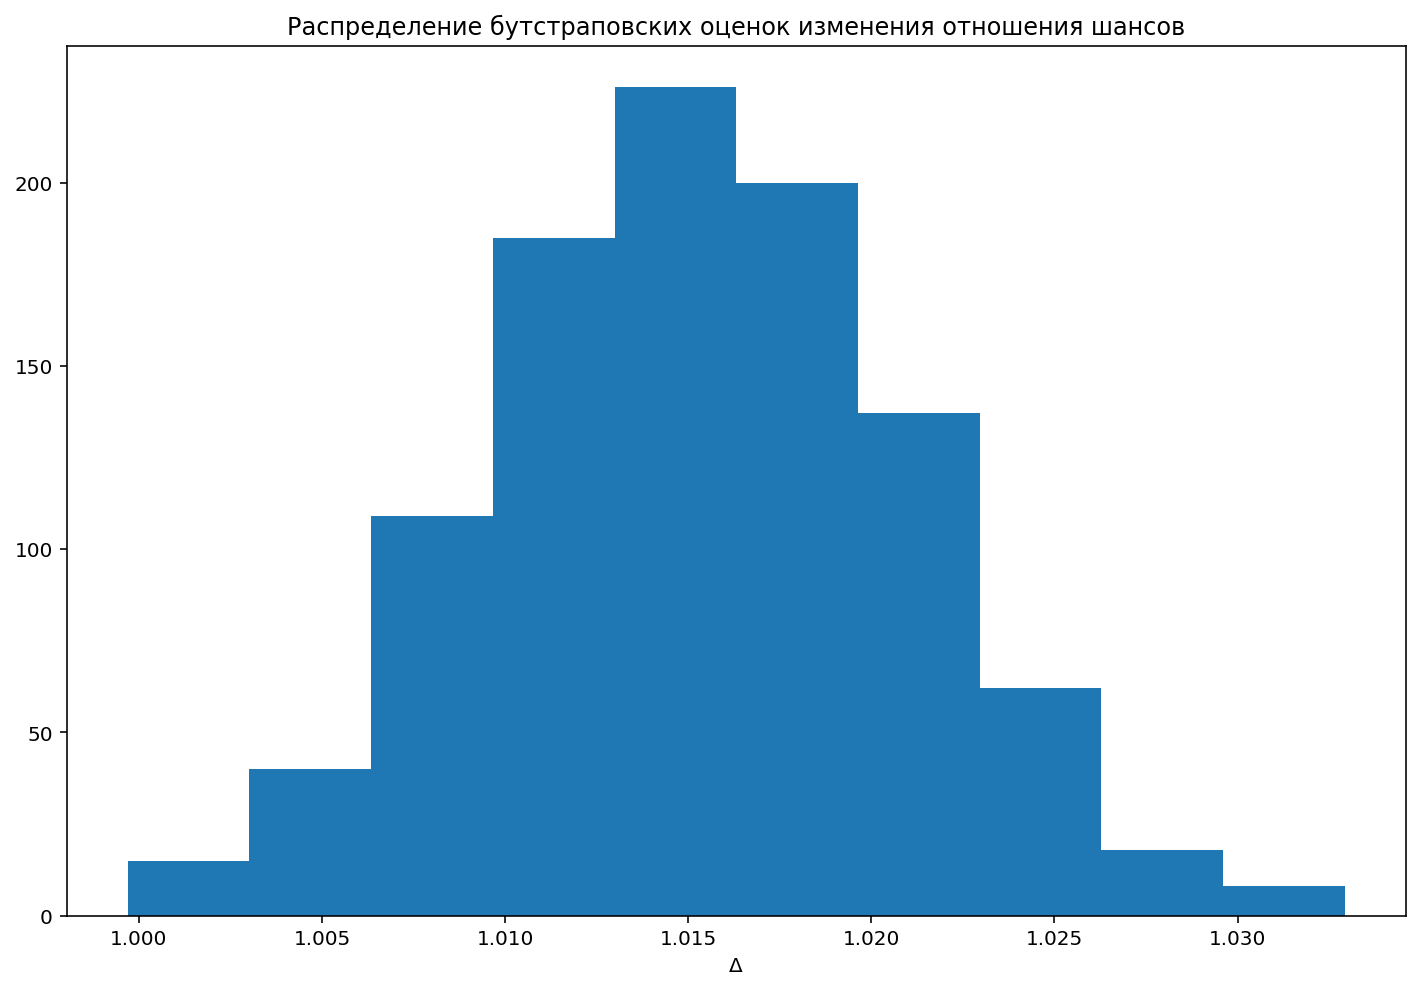

In [45]:
plt.title('Распределение бутстраповских оценок изменения отношения шансов')
plt.hist(all_estimates)
plt.xlabel('$\Delta$');

In [46]:
get_bootstrap_ci(all_estimates)

10% CI: [1.0060358467475046, 1.024513045473206]
5% CI: [1.0040203266960577, 1.0264552529662072]
1% CI: [1.0012112884889366, 1.0301274139810308]


Нулевая гипотеза отвергается на всех принятых уровнях значимости, так как 1,1 не попадает ни в один из интервалов выше

## Часть 6. Система бинарных уравнений

$\bf{6.1.}$ Оцените систему бинарных уравнений, одно из которых описывает вероятность подписки, а второе — вероятность того, что индивид смотрит телевизор не реже раза в неделю. При этом оба уравнения должны иметь по крайней мере одну общую и одну различающуюся независимую переменную. При необходимости спецификация уравнения подписки может отличаться от той, что использовалась в предыдущих разделах.

$\bf{\text{Мое решение:}}$ 

Уравнение подписки оставим без изменений, во втором уравнении (с просмотром ТВ) будем использовать возраст (age), наличие брака (marriage) и долю свободного времени, проводимого в интернете (internet). Оценим:

In [47]:
%%R

sub_formula <- sub ~ age + I(age ^ 2) +     
                            male + series +
                            male * series
tv_formula <- TV ~ age + marriage + internet                 
model_bp <- gjrm(formula = list(sub_formula,        
                                tv_formula),        
                 data = df_r,
                 Model = "B",                           
                                                        
                 margins = c("probit", "probit"),       
                                                        
                 BivD = "N")                            

summary(model_bp) 


COPULA:   Gaussian
MARGIN 1: Bernoulli
MARGIN 2: Bernoulli

EQUATION 1
Link function for mu.1: probit 
Formula: sub ~ age + I(age^2) + male + series + male * series

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.998e+00  1.485e-01 -13.457   <2e-16 ***
age          1.154e-02  4.834e-03   2.386   0.0170 *  
I(age^2)    -7.832e-05  3.956e-05  -1.980   0.0477 *  
male         1.459e+00  8.202e-02  17.785   <2e-16 ***
series       9.493e-02  1.076e-02   8.825   <2e-16 ***
male:series -1.010e-02  1.350e-02  -0.748   0.4544    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


EQUATION 2
Link function for mu.2: probit 
Formula: TV ~ age + marriage + internet

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.084428   0.066016  -1.279    0.201    
age          0.015312   0.000846  18.101   <2e-16 ***
marriage     0.027823   0.039633   0.702    0.483    
internet    -1.056018   0.074

$\bf{6.2.}$ Проинтерпретируйте оценки коэффициентов при независимых переменных и коэффициента корреляции между случайными ошибками рассматриваемых уравнений.

$\bf{\text{Мое решение:}}$ 

Исходя из результатов оценивания, мужской пол и количество просмотренных сериалов положительно влияют на вероятность иметь подписку, коэффициент при взаимодействии этих переменных оказался незначим. Коэффициенты в линейном индексе при возрасте оказались значимыми, коэффициент при линейной частью оказался положительным, а при квадратичной $-$ отрицательным. Максимальная вероятность подписки достигается в 74 года (аналогично результатам интерпретации в пробите).

В то же время возраст положительно влияет на вероятность просмотра телевизора, доля времени в интернете $-$ отрицательно (что очень жизненно понятно). Влияние брака на вероятность просмотра телевизора оказалось незначимым.

Корелляция между случайными ошибками (можно сказать, во влиянии факторов, которые не учтены в модели) оказалась значимо отрицательной. Этот коэфициент можно интерпретировать как то, что невключенные факторы в противопложном направлении влияют на вероятности иметь подписку/просматривать телевизор, то есть, если эти факторы увеличивают вероятность просмотра ТВ, то в то же время они снижают вероятность подписки и наоборот (что тоже очень логично).

In [48]:
-1.154e-02 / 2 / -7.832e-05

73.67211440245148

$\bf{6.3.}$ При помощи LR теста проверьте, имеется ли необходимость в том, чтобы оценивать оба уравнения совместно.

$\bf{\text{Мое решение:}}$ 

Модель, оценивающая отдельно два уравнения, является моделью с ограничением, так как в ней подразумевается, что $\rho = 0$ (одно ограничение)

$$ H_0: \rho=0 \text{ (одно ограничение)}$$

Тестовая статистика
$$ LR = -2(l_R(\hat{\beta}_R) - l_{UR}(\hat{\beta}_{UR})) $$

имеет распределение $\chi^2(1)$ при верной нулевой гипотезе

Полная модель $-$ оцененная нами выше система бинарный уравнений. Выполним тест:

In [49]:
%%R
# полная модель
lnL_unrestricted <- logLik(model_bp)

# ограниченная состоит из двух отдельных
model.probit1 <- glm(formula = sub_formula,   
                    data = df_r, family = binomial(link = "probit"))                                                            
l1 <-  logLik(model.probit1)

model.probit2 <- glm(formula = tv_formula,   
                    data = df_r, family = binomial(link = "probit"))                                                           
l2 <- logLik(model.probit2)

# правдоподобие = сумма двух отдельных моделей
lnL_restricted <- l1 + l2

LR_ratio <- -2 * (lnL_restricted[1] - lnL_unrestricted[1])

p.value <- as.numeric(1 - pchisq(LR_ratio, df = 1))  
print(p.value)

[1] 0


 Так как p-value равно нулю, то нулевая гипотеза отвергается, есть статистически значимая разница между ограниченной и неограниченной моделями, поэтому необходимо оценивать модели совместно, что логично, ведь оцененный в системе коэффициент корелляции случайных ошибок был значим (сильно отличен от нуля)

$\bf{6.4.}$ Для индивида с произвольными характеристиками оцените:
1. Вероятность подписки
2. Вероятность того, что индивид смотрит телевизор по крайней мере раз в неделю
3. Вероятность того, что индивид и имеет подписку, и смотрит телевизор не реже раза в неделю
4. Вероятность того, что у индивида имеется подписка, при условии, что он смотрит телевизор реже раза в неделю

$\bf{\text{Мое решение:}}$ 

Используем характеристики индивида из пункта 3.3. Добавим, что индивид проводит 80% свободного времени в Интернете и не состоит в браке.

In [50]:
%%R

Mark <- data.frame(age = 21,                             # характеристики произвольного индивида
                    male = 1,
                    series = 4,
                    cat = 0, marriage = 0, internet=0.8)

In [51]:
%%R
# характеристики произвольного индивида

x_sub <- c(1, 21, 21 ^ 2, 1, 4, 4)
x_tv <- c(1, 21, 0, 0.8)

coefs_sub <- model_bp$coefficients[1:6]
li_sub <- x_sub %*% coefs_sub

coefs_tv <- model_bp$coefficients[7:10]
li_tv <- x_tv %*% coefs_tv

rho_est <- model_bp$theta

rho_est

     theta 
-0.5156147 


1. Вероятность подписки

In [52]:
%%R
p_sub <- predict(model_bp, eq = 1, type = "response",   # вероятность стабильной
               newdata = Mark)
p_sub

        1 
0.5030817 


Оценка вероятности подписки равна 0,5

2. Вероятность того, что индивид смотрит телевизор по крайней мере раз в неделю

In [53]:
%%R
p_TV <- predict(model_bp, eq = 2, type = "response",   # вероятность стабильной
               newdata = Mark)
p_TV

       1 
0.271698 


Оценка вероятности просмотра телевизора по крайней мере раз в неделю равна 0,27

3. Вероятность того, что индивид и имеет подписку, и смотрит телевизор не реже раза в неделю

In [54]:
%%R
pbivnorm(x = cbind(li_sub, li_tv), rho = rho_est)

[1] 0.06634522


Оценка вероятности и подписки, и просмотра телевизора по крайней мере раз в неделю равна 0,07

4. Вероятность того, что у индивида имеется подписка, при условии, что он смотрит телевизор реже раза в неделю

In [55]:
%%R
p_sub1_tv0 <- pbivnorm(x = cbind(li_sub, -li_tv), rho = -rho_est)
p_tv0 <- 1 - pnorm(li_tv)

p_sub1_tv0 / p_tv0

         [,1]
[1,] 0.599664


Оценка вероятности наличия подписки при условии того, что индивид смотрит телевизор реже раза в неделю, равна 0,6

$\bf{6.5.^{**}}$ Для индивида с произвольными характеристиками оцените предельный
эффект общей для двух уравнений переменной на вероятность того, что индивид имеет подписку, при условии, что во втором уравнении зависимая бинарная переменная примет единичное значение. Запишите использовавшуюся для расчетов формулу.

$\bf{\text{Мое решение:}}$ 

Пусть $\beta_1$, $\beta_2$ $-$ коэффициенты в первой и второй уравнении, соответственно. Тогда для индивида с характеристиками $x$ условная вероятность будет следующей:

$$
P(Sub=1 | TV=1) = \frac{P(Sub=1, TV=1)}{P(TV=1)} =\frac{\Phi(x'\beta_1,\, x'\beta_2,\, \rho)}{\Phi(x'\beta_2)}
$$

Возьмем производную от этой функции по Age (обозначим $x_s$), было на лекции:

$$
A = \frac{\partial \Phi(x'\beta_1,\, x'\beta_2,\, \rho)}{\partial x_s} = \phi(x'\beta_1) \cdot \Phi\left(\frac{x'\beta_2- \rho x'\beta_1}{\sqrt{1-\rho^2}}\right) \cdot (\beta_{11} + 2\beta_{12} x_s) + 
\phi(x'\beta_2) \cdot \Phi\left(\frac{x'\beta_1 - \rho x'\beta_2}{\sqrt{1-\rho^2}}\right) \cdot \beta_{21}
$$


Тогда

$$
\frac{\partial P(Sub=1 | TV=1)}{\partial x_s} = \frac{A \cdot \Phi(x'\beta_2) - \Phi(x'\beta_1,\, x'\beta_2,\, \rho) \cdot \phi(x'\beta_2)\cdot\beta_{21}}{\left( \Phi(x'\beta_2)  \right) ^2}
$$

In [56]:
%%R

coefs_sub

  (Intercept)           age      I(age^2)          male        series 
-1.997997e+00  1.153580e-02 -7.832099e-05  1.458676e+00  9.493401e-02 
  male:series 
-1.010082e-02 


In [57]:
%%R

coefs_tv

(Intercept)         age    marriage    internet 
-0.08442822  0.01531225  0.02782288 -1.05601820 


In [58]:
beta1 = np.array([-1.997997e+00, 1.153580e-02, -7.832099e-05, 1.458676e+00, 9.493401e-02, -1.010082e-02])
beta2 = np.array([-0.08442822, 0.01531225, 0.02782288, -1.05601820])

x1 = np.array([1, 21, 441, 1, 4, 4]) 
x2 = np.array([1, 21, 0, 0.8]) 

li1 = x1 @ beta1
li2 = x2 @ beta2

rho = -0.5156147

Phi_li2 = scipy.stats.norm.cdf(li2)
phi_li1 = scipy.stats.norm.pdf(li1)
phi_li2 = scipy.stats.norm.pdf(li2)
Phi = scipy.stats.multivariate_normal.cdf([li1, li2], cov=np.array([[1, rho],
                                                                    [rho, 1]]))
Phi_diff21 = scipy.stats.norm.cdf((li2 - rho* li1)/np.sqrt(1-rho**2))
Phi_diff12 = scipy.stats.norm.cdf((li1 - rho* li2)/np.sqrt(1-rho**2))

A = phi_li1 * Phi_diff21 * (beta1[1] + 2 * beta1[2] * x1[1]) + phi_li2 * Phi_diff12 * beta2[1]

answer = (A * Phi_li2 - Phi * phi_li2 * beta2[1]) / (Phi_li2 ** 2)
answer

0.005089713573067831

Предельный эффект по возрасту для условной вероятности для индивида с произвольными характеристиками получился равным 0.005

## Часть 7. Сравнение моделей

$\bf{7.1.}$ Определите, какая из оцененных вами моделей обладает наибольшей предсказательной силой.

$\bf{\text{Мое решение:}}
$

Посчитаем accuracy на тренировочной выборке для всех моделей при пороге 0.5:

In [59]:
%%R

threshold <- 0.5

pred.linear <- as.numeric(predict(model.lm) >= threshold)
pred.probit <- as.numeric(predict(model.probit, type='response') >= threshold)
pred.logit <- as.numeric(predict(model.logit, type='response') >= threshold)
pred.system <- as.numeric(predict(model_bp, eq=1, type='response') >= threshold)

rbind(naive = max(mean(df_r$sub), 1-mean(df_r$sub)),
      linear = mean(pred.linear == df_r$sub),
      probit = mean(pred.probit == df_r$sub),                             
      logit = mean(pred.logit == df_r$sub),                             
      system = mean(pred.system == df_r$sub)) * 100  

        [,1]
naive  63.92
linear 74.34
probit 74.38
logit  74.52
system 74.14


Наибольшее качество у логистической модели (заметим, что accuracy совпадают с Питоновскими, что мы считали ранее)

$\bf{7.2.}$ Выберите лучшую из оцененных вами моделей руководствуясь информационными критериями.


$\bf{\text{Мое решение:}}$ 

Так как в системе оценивается сразу два уравнения, а значит, функция правдоподобия совершенно отличается от тех, что при всех наших других моделях, то по критериям мы можем сравнивать лишь моедли с одним уравнением:

AIC:

In [60]:
%%R
rbind(linear = AIC(model.lm),
      probit = AIC(model.probit),
      logit = AIC(model.logit))

           [,1]
linear 5398.464
probit 5187.128
logit  5186.292


BIC:

In [61]:
%%R
rbind(linear = BIC(model.lm),
      probit = BIC(model.probit),
      logit = BIC(model.logit))

           [,1]
linear 5444.084
probit 5226.231
logit  5225.395


По обоим информационным критериям (AIC и BIC) лучшей оказалась вновь модель логистической регрессии (они наименьшие при ней).

Систему можно сравнить по критериям против двух независимых моделей (Богдан Станиславович одобрил):

AIC:

In [62]:
%%R

model.probit1 <- glm(formula = sub_formula,   
                    data = df_r, family = binomial(link = "probit"))

model.probit2 <- glm(formula = tv_formula,   
                    data = df_r, family = binomial(link = "probit"))

AIC_probit_probit <- AIC(model.probit1) + AIC(model.probit2)
BIC_probit_probit <- BIC(model.probit1) + BIC(model.probit2)

model.linear1 <- lm(formula = sub_formula,   
                    data = df_r)

model.linear2 <- lm(formula = tv_formula,   
                    data = df_r)

AIC_linear_linear <- AIC(model.linear1) + AIC(model.linear2)
BIC_linear_linear <- BIC(model.linear1) + BIC(model.linear2)

model.logit1 <- glm(formula = sub_formula,   
                    data = df_r, family = binomial(link = "logit"))

model.logit2 <- glm(formula = tv_formula,   
                    data = df_r, family = binomial(link = "logit"))

AIC_logit_logit <- AIC(model.logit1) + AIC(model.logit2)
BIC_logit_logit <- BIC(model.logit1) + BIC(model.logit2)

rbind(linear = AIC_linear_linear,
      probit = AIC_probit_probit ,
      logit = AIC_logit_logit, 
      system = AIC(model_bp))

           [,1]
linear 11637.09
probit 11107.15
logit  11109.94
system 10748.04


BIC:

In [63]:
%%R

rbind(linear = BIC_linear_linear,
      probit = BIC_probit_probit ,
      logit = BIC_logit_logit, 
      system = BIC(model_bp))

           [,1]
linear 11715.29
probit 11172.33
logit  11175.11
system 10819.73


Получилось, что если мы хотим оценивать два уравнения (с подпиской и ТВ), то с точки зрения обоих информационных критериев лучше использовать систему (бипробит)

$\bf{7.3.^{**}}$ Руководствуясь информационным критерием Акаике и качеством вневыборочного прогноза (разделите выборку на тестовую и тренировочную части) определите оптимальные маржинальные распределения для случайных ошибок и копулу. Укажите, совпадают ли лучшие модели, выбранные по AIC и вневыборочному прогнозу. В данном задании рассмотрите по крайней мере 5 различных копул и две различные комбинации маржинальных распределений случайных ошибок. Результат представьте в форме таблицы.

$\bf{\text{Мое решение:}}$ 

Судя по условию, этот пункт относится только к модели системы.

Возьмем следующие комбинации маржинальных распределений: (Пробит, Пробит), (Пробит, Логит).
Также попробуем пять видов копул: Гауссову, Фрэнка, Гумбеля, Стьюдента и Фарли-Гумбеля-Моргенштерна.

Возьмем отложенную выборку размера 1000, в тренировочной будет 4000 наблюдений.

In [64]:
%%R

set.seed(999)                                              # для воспроизводимости
n <- nrow(df_r)                                               # число наблюдений
n.train <- round(0.8 * n)                                  # число наблюдений в
                                                           # тренировочной и
n.test <- n - n.train                                      # тестовой выборках
ind.train <- sample(1:n, n.train)                          # индексы наблюдений, попадающих
                                                           # в тренировочную выборку
h.train <- df_r[ind.train, ]                                  # тренировочная выборка
h.test <- df_r[-ind.train, ]   

In [65]:
%%R

margins <- list(c("probit", "logit"), c("probit", "probit"))
copulas <- list("N", 'F', 'G0', 'T', 'FGM')

AICs <- list()
accuracy_list <- list()


for(marg in margins)                       
{ for(copula in copulas){

    # модель для подсчета Аика
    current_model_full <- gjrm(formula = list(sub_formula,        
                                tv_formula),        
                 data = df_r,
                 Model = "B",                                                     
                 margins = marg,                                      
                 BivD = copula)  
    
    AICs <- append(AICs, AIC(current_model_full))
    
    val_model <- gjrm(formula = list(sub_formula,        
                                tv_formula),        
                 data = h.train,
                 Model = "B",                                                             
                 margins = marg,                                        
                 BivD = copula)
    
    val_preds <- as.numeric(predict(val_model, new_data=h.test, type='response', eq=1) >= 0.5)
    val_accuracy <- mean(val_preds == h.test$sub) * 100 
    accuracy_list <- append(accuracy_list, val_accuracy)
}}

In [66]:
%%R
AICs

[[1]]
[1] 10750.36

[[2]]
[1] 10756.3

[[3]]
[1] 11112.77

[[4]]
[1] 10750.23

[[5]]
[1] 10800.33

[[6]]
[1] 10748.04

[[7]]
[1] 10753.89

[[8]]
[1] 11109.15

[[9]]
[1] 10747.71

[[10]]
[1] 10797.64



In [67]:
%%R
accuracy_list

[[1]]
[1] 53.35

[[2]]
[1] 53.4

[[3]]
[1] 51.25

[[4]]
[1] 53.2

[[5]]
[1] 52.65

[[6]]
[1] 53.3

[[7]]
[1] 53.4

[[8]]
[1] 51.25

[[9]]
[1] 53.2

[[10]]
[1] 52.75



Так как тут очень плохо отображаются таблицы в R, перебьем данные в Питон:

In [68]:
copulas = ["N", 'F', 'G0', 'T', 'FGM']
margins = [("probit", "logit"), ("probit", "probit")]

margins_list = []
copulas_list = []

for i in margins:
    for j in copulas:
        margins_list.append(i)
        copulas_list.append(j)
        
AICs = [ 10750.36, 10756.3, 11112.77, 10750.23, 10800.33,
 10748.04, 10753.89, 11109.15, 10747.71, 10797.64]

val_accs = [53.35, 53.4, 51.25, 53.2,
 52.65, 53.3, 53.4, 51.25, 53.2, 52.75]

pd.DataFrame(zip(margins_list, copulas_list, AICs, val_accs), columns=['Margins combo', 'Copula', 
                                                                       'AIC', 'Validation Accuracy'])

,Margins combo,Copula,AIC,Validation Accuracy
0,"(probit, logit)",N,10750.36,53.35
1,"(probit, logit)",F,10756.30,53.40
2,"(probit, logit)",G0,11112.77,51.25
3,"(probit, logit)",T,10750.23,53.20
4,"(probit, logit)",FGM,10800.33,52.65
5,"(probit, probit)",N,10748.04,53.30
6,"(probit, probit)",F,10753.89,53.40
7,"(probit, probit)",G0,11109.15,51.25
8,"(probit, probit)",T,10747.71,53.20
9,"(probit, probit)",FGM,10797.64,52.75


Лучшими с точки зрения прогностической силы на валидации (отложенной выборке) оказались модели c копулой Фрэнка. Обе комбинации маржинальных распределений с этой копулой показали лучшее качество в 53,4%.

Лучшей с точки зрения критерия Акаике оказалась модель с копулой Стьюдента и комбинацией маржинальных (Пробит, Пробит). Значение информационного критерия при этой модели было наименьшим и равнялось 10747.71.

Таким образом, лучшие по Акаике и вневыборочному прогнозу модели не совпадают.

Заметим, что доля верных прогнозов на валидации значительно меньше той, что была, когда мы обучали модель на всей выборке и на ней же измеряли качество. На это есть несколько причин: 1) несбалансированность классов в трейне и тесте (в исходной выборке около 35% единиц), возможно, стоило подобрать оптимальный порог, 2) переобучение и качество в 53% является более показательным.

## Часть 8. Модель бинарного выбора со случайными ошибками, имеющими распределение Стьюдента

Рассмотрим распределение Стьюдента с df степенями свободы, где df равняется сумме букв в ваших имени и фамилии.

$\bf{8.1.^{***}}$ Используя воображение придумайте и кратко опишите экономическую задачу, для решения которой необходимо применить модель бинарного выбора. Например, можно рассмотреть влияние различных факторов на вероятность дефолта банка. Укажите
зависимую переменную и по крайней мере три независимых, а также кратко опишите предполагаемый механизм влияния независимых переменных на зависимую.


$\bf{\text{Мое решение:}}$ 

Определить для человека вероятность быть принятым на работу в компанию N (может быть полезно для желающих найти работу). Бинарная переменная $-$ принят или нет кандидат на работу. Объясняющие переменные: стаж (непрерывная, чем больше стаж, тем выше вероятность быть принятым на работу (работодатель воспринимает это как сигнал)), пол (бинарная, 1 $-$ мужчина, вообще должна быть незначима, но предположим, что компания N немного дискриминирует, поэтому у мужчин при прочих равных вероятность найти работу немного выше), iQ (непрерывная, чем выше iQ, тем выше вероятность быть принятым: пройти собеседование, работодатель хочет нанимать самых сообразительных)

$\bf{8.2.^{***}}$ Симулируйте процесс генерации данных, соответствующий вашей задаче в логике бинарной модели со случайными ошибками, имеющими распределение Стьюдента (по аналогии с тем, как это делалось для обычной пробит модели для дефолта на семинаре). В тексте работы этот пункт отражать не нужно, достаточно реализовать его в коде. Все дальнейшие пункты выполняются на симулированных данных из выборки объемом 5000 наблюдений. Перед началом симуляций необходимо указать set.seed(123).

$\bf{\text{Мое решение:}}$ 

In [69]:
np.random.seed(123)

n = 5000
degrees = len('МаркСтоляров')

exper = np.random.poisson(lam=10, size=n)
sex = np.random.choice([0, 1], size=n, p=[0.49, 0.51])
iq = np.round(np.random.normal(loc=100, scale=10, size=n))

X = np.vstack([np.ones(n), exper, sex, iq]).T

eps = np.random.standard_t(degrees, size=n)
betas = [-320, 2, 1, 3]

y = (X @ betas + eps > 0) * 1

y.mean()

0.507

$\bf{8.3.^{***}}$ Оцените параметры вашей модели с использованием бинарной модели со случайными ошибками, имеющими распределение Стьюдента с df степенями свободы. Результат представьте в форме таблицы, содержащей оценки коэффициентов и p-value тестов на значимость.

$\bf{\text{Мое решение:}}$ 

Как всегда в таких ситуациях будем использовать бутстрап

Бутстрапом у нас не получится рассчитать p-value, однако получится рассчитать оценки, стандартные отклонения, и доверительные интервалы:

In [70]:
def negloglikelihood(beta, X=X, y=y, degrees=degrees):
    '''
    Функция отрицательного правдоподобия
    '''
    probs = np.zeros(len(y))
    probs[y == 1] = scipy.stats.t.cdf(X @ beta, df=degrees)[y == 1] 
    probs[y == 0] = (1 - scipy.stats.t.cdf(X @ beta, df=degrees))[y == 0] 
    return -np.sum(np.log(probs))

negloglikelihood(betas, X=X, y=y)

150.02693554648573

In [71]:
np.random.seed(999)

# будем считать ошибки бутстрапом
all_estimates = []

for i in tqdm(range(200)):
    sub_idx = np.random.choice(n, size=n, replace=True)
    X_sub, y_sub = X[sub_idx], y[sub_idx]
    coefs = scipy.optimize.minimize(negloglikelihood, [0, 0, 0, 0], args=(X_sub, y_sub),
                                    method='Nelder-Mead').x
    all_estimates.append(coefs)

np.mean(all_estimates, axis=0)

  0%|          | 0/200 [00:00<?, ?it/s]

array([-313.93618218,    1.89957931,    0.83364622,    2.95089485])

Оценки нашей модели получились довольно близкими, что подтверждает, что мы сделали все правильно.
Будем использовать 5% доверительный интервал:

In [72]:
print('beta0')
get_bootstrap_ci(np.array(all_estimates)[:, 0])
print('')
print('beta1')
get_bootstrap_ci(np.array(all_estimates)[:, 1])
print('')
print('beta2')
get_bootstrap_ci(np.array(all_estimates)[:, 2])
print('')
print('beta3')
get_bootstrap_ci(np.array(all_estimates)[:, 3])

beta0
10% CI: [-353.30467311173555, -276.6287135088204]
5% CI: [-360.4916111970442, -273.86600644399175]
1% CI: [-385.40646467895806, -265.5436465922739]

beta1
10% CI: [1.6709081646077557, 2.1478410895351367]
5% CI: [1.6361613317252404, 2.1916971704881982]
1% CI: [1.6128359066129734, 2.334012109509959]

beta2
10% CI: [0.4815024467760688, 1.200524900196057]
5% CI: [0.39839085628961857, 1.234912619969615]
1% CI: [0.2852780901090071, 1.282610735909954]

beta3
10% CI: [2.6022757440953233, 3.3236127692136757]
5% CI: [2.579088180904616, 3.3962045766129836]
1% CI: [2.4920048000069315, 3.6271684495094467]


Заметим, что на всех уровнях значимости, гипотезы о равенстве коэффициентов нулю отвергается

In [73]:
cis5percent = np.round([[-360.4916111970442, -273.86600644399175], [1.6361613317252404, 2.1916971704881982], 
               [0.39839085628961857, 1.234912619969615], [2.579088180904616, 3.3962045766129836]], 3)

all_estimates = np.array(all_estimates)

variables = ['intercept', 'experience', 'sex', 'IQ']
ests = np.mean(all_estimates, axis=0)
stds = np.sqrt(np.var(all_estimates * 200 / 199, axis=0))

results = pd.DataFrame(zip(betas, ests, stds, cis5percent), 
                       columns=['real', 'coef', 'std', '5% CI'], index=variables)
results

,real,coef,std,5% CI
intercept,-320,-313.936182,24.696981,"[-360.492, -273.866]"
experience,2,1.899579,0.152040,"[1.636, 2.192]"
sex,1,0.833646,0.225625,"[0.398, 1.235]"
IQ,3,2.950895,0.232137,"[2.579, 3.396]"


Также можно сделать очень грубое предположение, что оценки в нашей бутстрапированной выборке являются слабо независимыми одинаково распределенными случайными величинами и тогда (по ЦПТ) среднее от выборки будет распределено нормально и мы сможем найти нужное p-value

In [74]:
zs = ests / stds
pvalues = 2 * (1 - scipy.stats.norm.cdf(np.abs(zs)))

results = pd.DataFrame(zip(betas, ests, stds, pvalues), columns=['real', 'coef', 'std', 'p-value'], index=variables)
results

,real,coef,std,p-value
intercept,-320,-313.936182,24.696981,0.00000
experience,2,1.899579,0.152040,0.00000
sex,1,0.833646,0.225625,0.00022
IQ,3,2.950895,0.232137,0.00000


Все коэффициенты оказались сильно значимыми как по бутстрапированным доверительным интервалам, так и по рассчитанным нами "p-value"

$\bf{8.4.^{***}}$ Напишите функцию, позволяющую рассчитывать предельный эффект на вероятность по произвольной непрерывной переменной в отношении индивида с произвольными характеристиками: для простоты переменными, входящими нелинейно, можно пренебречь. При помощи данной функции оцените предельный эффект произвольной непрерывной переменной на вероятность успеха для индивида с произвольными характеристиками.

$\bf{\text{Мое решение:}}$ 

Посчитаем предельный эффект с помощью численных методов для индивида со стажем в 15 лет, мужского пола , имеющим IQ 90:

In [75]:
def calculate_ME(num_variable, x):
    '''
    Функция считает предельный эффект по num_variable-ой переменной для индивда с характеристиками x.
    1 - experience, 3 - IQ (переменная должна быть непрерывной)
    '''
    delta = 1e-6
    
    add_to_x = np.zeros(len(x))
    add_to_x[num_variable] += delta
    
    y_latent0 = ests.T @ x
    proba0 = scipy.stats.t.cdf(y_latent0, df=degrees)

    y_latent1 = ests.T @ (x + add_to_x)
    proba1 = scipy.stats.t.cdf(y_latent1, df=degrees)
    
    return (proba1 - proba0) / delta 

calculate_ME(3, [1, 15, 1, 90]) # предельный эффект по IQ

2.2504091787904257e-10

Предельный эффект для произвольного индивида по IQ равен 2.25e-10

8.5***. Симулируйте процесс генерации данных таким образом, чтобы дисперсия случайной ошибки зависела по крайней мере от двух независимых переменных, одна из которых не входит в основное уравнение. Выполните одно задание на выбор:
* Напишите функцию, осуществляющую LM тест на гомоскедастичность случайных ошибок в рамках вашей модели. Воспользуйтесь вашей функцией и опишите полученный результат.

* Напишите функцию, при помощи которой можно оценить параметры модели бинарного выбора с гетероскедастичной случайной ошибкой, имеющей распределение Стьюдента с df степенями свободы. При помощи вашей функции и LR теста проверьте гипотезу о гомоскедастичности случайных ошибок.

$\bf{\text{Мое решение:}}$ 

Выберем второй пункт, далее напишем функцию, считающую правдоподобие полной модели.

Переделаем процесс генерации данных таким образом, чтобы ошибка $e$ зависела от стажа и фактора счастья работодателя следующим образом:

$$
e_i = \frac{\varepsilon_i}{(-0.01  Exp_i + 0.01  Happiness_i + 1) ^ 2 }, 
$$

где $\varepsilon_i \sim t(df)$. В библиотеке scipy.stats это легко воспроизвести, используя параметр scale. Таким образом, будет гетероскедастичность. Будем оценивать полную модель, в которой вид гетероскедастичности полностью угадывается, кроме коэффициентов при переменных. В ограниченной модели будет предположение, что оба коэффициента в уравнении дисперсии равны нулю (то есть, дисперсия постоянна для любой ошибки, scale=1). Это и будет проверяемой нулевой гипотезой. Есть два ограничения, поэтому тестовая статистика имеет распределение $\chi^2(2)$.

Генерируем данные:

In [76]:
np.random.seed(123)

n = 50000 # возьмем 50000 наблюдений
degrees = len('МаркСтоляров')

exper = np.random.poisson(lam=10, size=n)
sex = np.random.choice([0, 1], size=n, p=[0.49, 0.51])
iq = np.round(np.random.normal(loc=100, scale=10, size=n))
happiness = np.round(np.random.normal(loc=20, scale=1, size=n))

X = np.vstack([np.ones(n), exper, sex, iq]).T

scales = (-0.01 * exper + 0.01 * happiness + 1) ** 2 

eps = scipy.stats.t.rvs(df=degrees, scale=scales, size=n) # генерируем ошибки с разной дисперсией
betas = [-3, 0.01, 1, 0.025]

y = (X @ betas + eps > 0) * 1

y.mean()

0.5346

Наша полная модель $-$ та, в которой scale зависит от параметров стажа и счастья работодателя. Ограниченная, соответственно, та, в которой предполагается гомоскедастичность. Функция правдоподобия полной модели:

In [77]:
def negloglikelihood_hetero(coefs, X=X, happiness=happiness, y=y, degrees=degrees):
    x_happy = happiness
    x_exper = X[:, 1]
    taus = coefs[:2]
    
    scale_pred = (taus[0] * x_exper + taus[1] * x_happy + 1) ** 2
    beta = coefs[2:]
    probs = np.zeros(len(y))
    probs[y == 1] = scipy.stats.t.cdf(X @ beta, scale=scale_pred, df=degrees)[y == 1] 

    probs[y == 0] = (1 - scipy.stats.t.cdf(X @ beta, scale=scale_pred, df=degrees))[y == 0] 
    return -np.sum(np.log(probs))


Найдем оценки полной и ограниченной (используемой раньше) модели и проведем тест:

In [78]:
coefs_r = scipy.optimize.minimize(negloglikelihood, [0, 0, 0, 0], args=(X, y, degrees),
                                    method='Nelder-Mead').x

coefs_ur = scipy.optimize.minimize(negloglikelihood_hetero, [2, 2, 1, 1, 1, 1], 
                                   args=(X, happiness, y, degrees),
                                   method='BFGS').x

l_R = -negloglikelihood_hetero(np.array([0, 0] + list(coefs_r)))
l_UR = -negloglikelihood_hetero(coefs_ur)

lr = 2 * (l_UR - l_R)

1 - scipy.stats.chi2.cdf(lr, df=2)

1.3967140975235104e-05

Так как p-value близко к нулю, то нулевая гипотеза о гомоскедастичности в моделе отвергается на всех принятых уровнях значимости (что логично, ведь именно так мы и симулировали данные). Значения логарифмов функций правдоподобия действительно отличаются:

In [79]:
l_UR, l_R

(-31661.421460588204, -31672.600263648448)

Посмотрим на соотношения оценок:

In [80]:
pd.DataFrame(zip(['tau_exper', 'tau_happiness', 'Const', 'Exper', 'IQ'], [-0.01, 0.01, -3, 0.01, 1, 0.025],
                np.round([0, 0] + list(coefs_r), 4), np.round(coefs_ur, 4)), 
             columns=['Coef', 'True', 'Restr', 'Unrestr'])

,Coef,True,Restr,Unrestr
0,tau_exper,-0.01,0.0000,-0.0110
1,tau_happiness,0.01,0.0000,0.0141
2,Const,-3.00,-2.4534,-3.3403
3,Exper,0.01,0.0067,0.0070
4,IQ,1.00,0.8085,1.1085


Видно, что оценки полной модели ближе к истинным, что подтверждает, что нельзя оценивать модель в предположении гомоскедастичности